# nav_remapping.ipynb

In [2]:
# General
import sys
import os
import os.path as op
from time import time
import warnings
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy as sp
import scipy.stats as stats
from scipy.spatial.distance import mahalanobis
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, time_bin_analysis, time_cell_plots, remapping

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [3]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [4]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

#     full_models = ['time', 'time_place', 'full']
#     full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
#     ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))
    
    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))

    
def _fr_max_ind(spike_mat, bins=10):
    return np.argmax([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])

icol = ols_pairs.columns.tolist().index('fr_max_ind') + 1
if 'fr_max_ind10' not in ols_pairs:
    ols_pairs.insert(icol, 'fr_max_ind10', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 10)))
if 'fr_max_ind5' not in ols_pairs:
    ols_pairs.insert(icol+2, 'fr_max_ind5', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 5)))

ols_pairs = ols_pairs.sort_values(['subj_sess_unit', 'gameState', 'testvar']).reset_index(drop=True)

print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

ols_pairs: (5027, 35)
Done in 0.9s


In [5]:
n_cells = len(set(ols_pairs['subj_sess_unit'].tolist()))

sig_cells = od([])
for game_state in ['Delay1', 'Encoding', 'Delay2', 'Retrieval']:
    for testvar in ols_pairs['testvar'].unique():
        qry = "(gameState=='{}') & (testvar=='{}') & (full=='full') & (sig==True) & (beta_abs_max>0)".format(game_state, testvar)
        _neurons = set(ols_pairs.query(qry)['subj_sess_unit'].tolist())
        k = '{}-{}'.format(game_state, testvar)
        if len(_neurons) > 0:
            sig_cells[k] = _neurons
            print(k, len(sig_cells[k]))

Delay1-time 58
Encoding-time 52
Encoding-place 47
Encoding-head_direc 30
Encoding-base_in_view 23
Encoding-gold_in_view 59
Delay2-time 46
Retrieval-time 44
Retrieval-place 54
Retrieval-head_direc 26
Retrieval-base_in_view 12


In [9]:
# Test independence of proportions between
# Delay1 and Delay2 time cells.
alpha = 0.05
ctab = [[n_cells - len(sig_cells['Delay1-time']), len(sig_cells['Delay1-time'])],
        [n_cells - len(sig_cells['Delay2-time']), len(sig_cells['Delay2-time'])]]

chi2, pval, df, _ = stats.chi2_contingency(ctab, correction=True)
print('contingency table : {}'.format(ctab),
      'χ2({}) = {:.1f}, p = {:.6f}, reject = {}'.format(df, chi2, pval, pval<alpha),
      sep='\n')

contingency table : [[399, 58], [411, 46]]
χ2(1) = 1.3, p = 0.251880, reject = False


In [13]:
# Test independence of overlap between cells coding
# for each game state x behavioral variable pair.
alpha = 0.05

n_cells = len(set(ols_pairs['subj_sess_unit'].tolist()))
gs_vars = list(sig_cells.keys())
pairs = [[gs_vars[ii], gs_vars[jj]]
         for ii in range(len(sig_cells))
         for jj in range(len(sig_cells))
         if (ii > jj)]

cols = ['gameState1', 'testvar1', 'gameState2', 'testvar2',
        'sig0', 'sig1', 'sig2', 'sig1or2',
        'sig1and2', 'sig1and2_exp', 'obs_sub_exp', 'obs_div_exp', 'chi2',
        'pval']
overlap = []
for k1, k2 in pairs:
    gs1, tv1 = k1.split('-')
    gs2, tv2 = k2.split('-')
    sig1or2 = len(sig_cells[k1] | sig_cells[k2])
    sig0 = n_cells - sig1or2
    sig1 = len(sig_cells[k1])
    sig2 = len(sig_cells[k2])
    sig1and2 = len(sig_cells[k1] & sig_cells[k2])
    ctab = [(sig0, sig1),
            (sig2, sig1and2)]
    chi2, pval, df, ctab_exp = stats.chi2_contingency(ctab, correction=True)
    sig1and2_exp = ctab_exp[1, 1]
    obs_sub_exp = sig1and2 - sig1and2_exp
    obs_div_exp = sig1and2 / sig1and2_exp
    overlap.append([gs1, tv1, gs2, tv2,
                    sig0, sig1, sig2, sig1or2,
                    sig1and2, sig1and2_exp, obs_sub_exp, obs_div_exp, chi2,
                    pval])
    
overlap = pd.DataFrame(overlap, columns=cols)

# Assess significance.
overlap['sig'] = overlap['pval'] < alpha
overlap['pval_fdr'] = sm.stats.multipletests(overlap['pval'], alpha, method='fdr_bh')[1]
overlap['sig_fdr'] = sm.stats.multipletests(overlap['pval'], alpha, method='fdr_bh')[0]

In [16]:
# sig
overlap.sort_values('chi2', ascending=0).query("(testvar1=='time') & (testvar2=='time')")

,gameState1,testvar1,gameState2,testvar2,sig0,sig1,sig2,sig1or2,sig1and2,sig1and2_exp,obs_sub_exp,obs_div_exp,chi2,pval,sig,pval_fdr,sig_fdr
22,Retrieval,time,Encoding,time,374,44,52,83,13,7.670807,5.329193,1.694737,3.983055,0.045960,True,1.0,False
15,Delay2,time,Delay1,time,366,46,58,91,13,8.672878,4.327122,1.498926,2.255343,0.133154,False,1.0,False
21,Retrieval,time,Delay1,time,363,44,58,94,8,7.255814,0.744186,1.102564,0.010730,0.917498,False,1.0,False
27,Retrieval,time,Delay2,time,372,44,46,85,5,5.351178,-0.351178,0.934374,0.005191,0.942563,False,1.0,False
0,Encoding,time,Delay1,time,355,52,58,102,8,8.372093,-0.372093,0.955556,0.002601,0.959326,False,1.0,False
16,Delay2,time,Encoding,time,365,46,52,92,6,6.430704,-0.430704,0.933024,0.000958,0.975303,False,1.0,False


0.634685598377282 1.7045714285714284
1.748720172925319e-06 6.777233191372217
[(0, 'Delay1-time'), (1, 'Delay2-time'), (2, 'Encoding-time'), (3, 'Retrieval-time'), (4, 'Encoding-place'), (5, 'Retrieval-place'), (6, 'Encoding-head_direc'), (7, 'Retrieval-head_direc'), (8, 'Encoding-is_moving'), (9, 'Retrieval-is_moving'), (10, 'Encoding-base_in_view'), (11, 'Retrieval-base_in_view'), (12, 'Encoding-gold_in_view'), (13, 'Retrieval-dig_performed')]


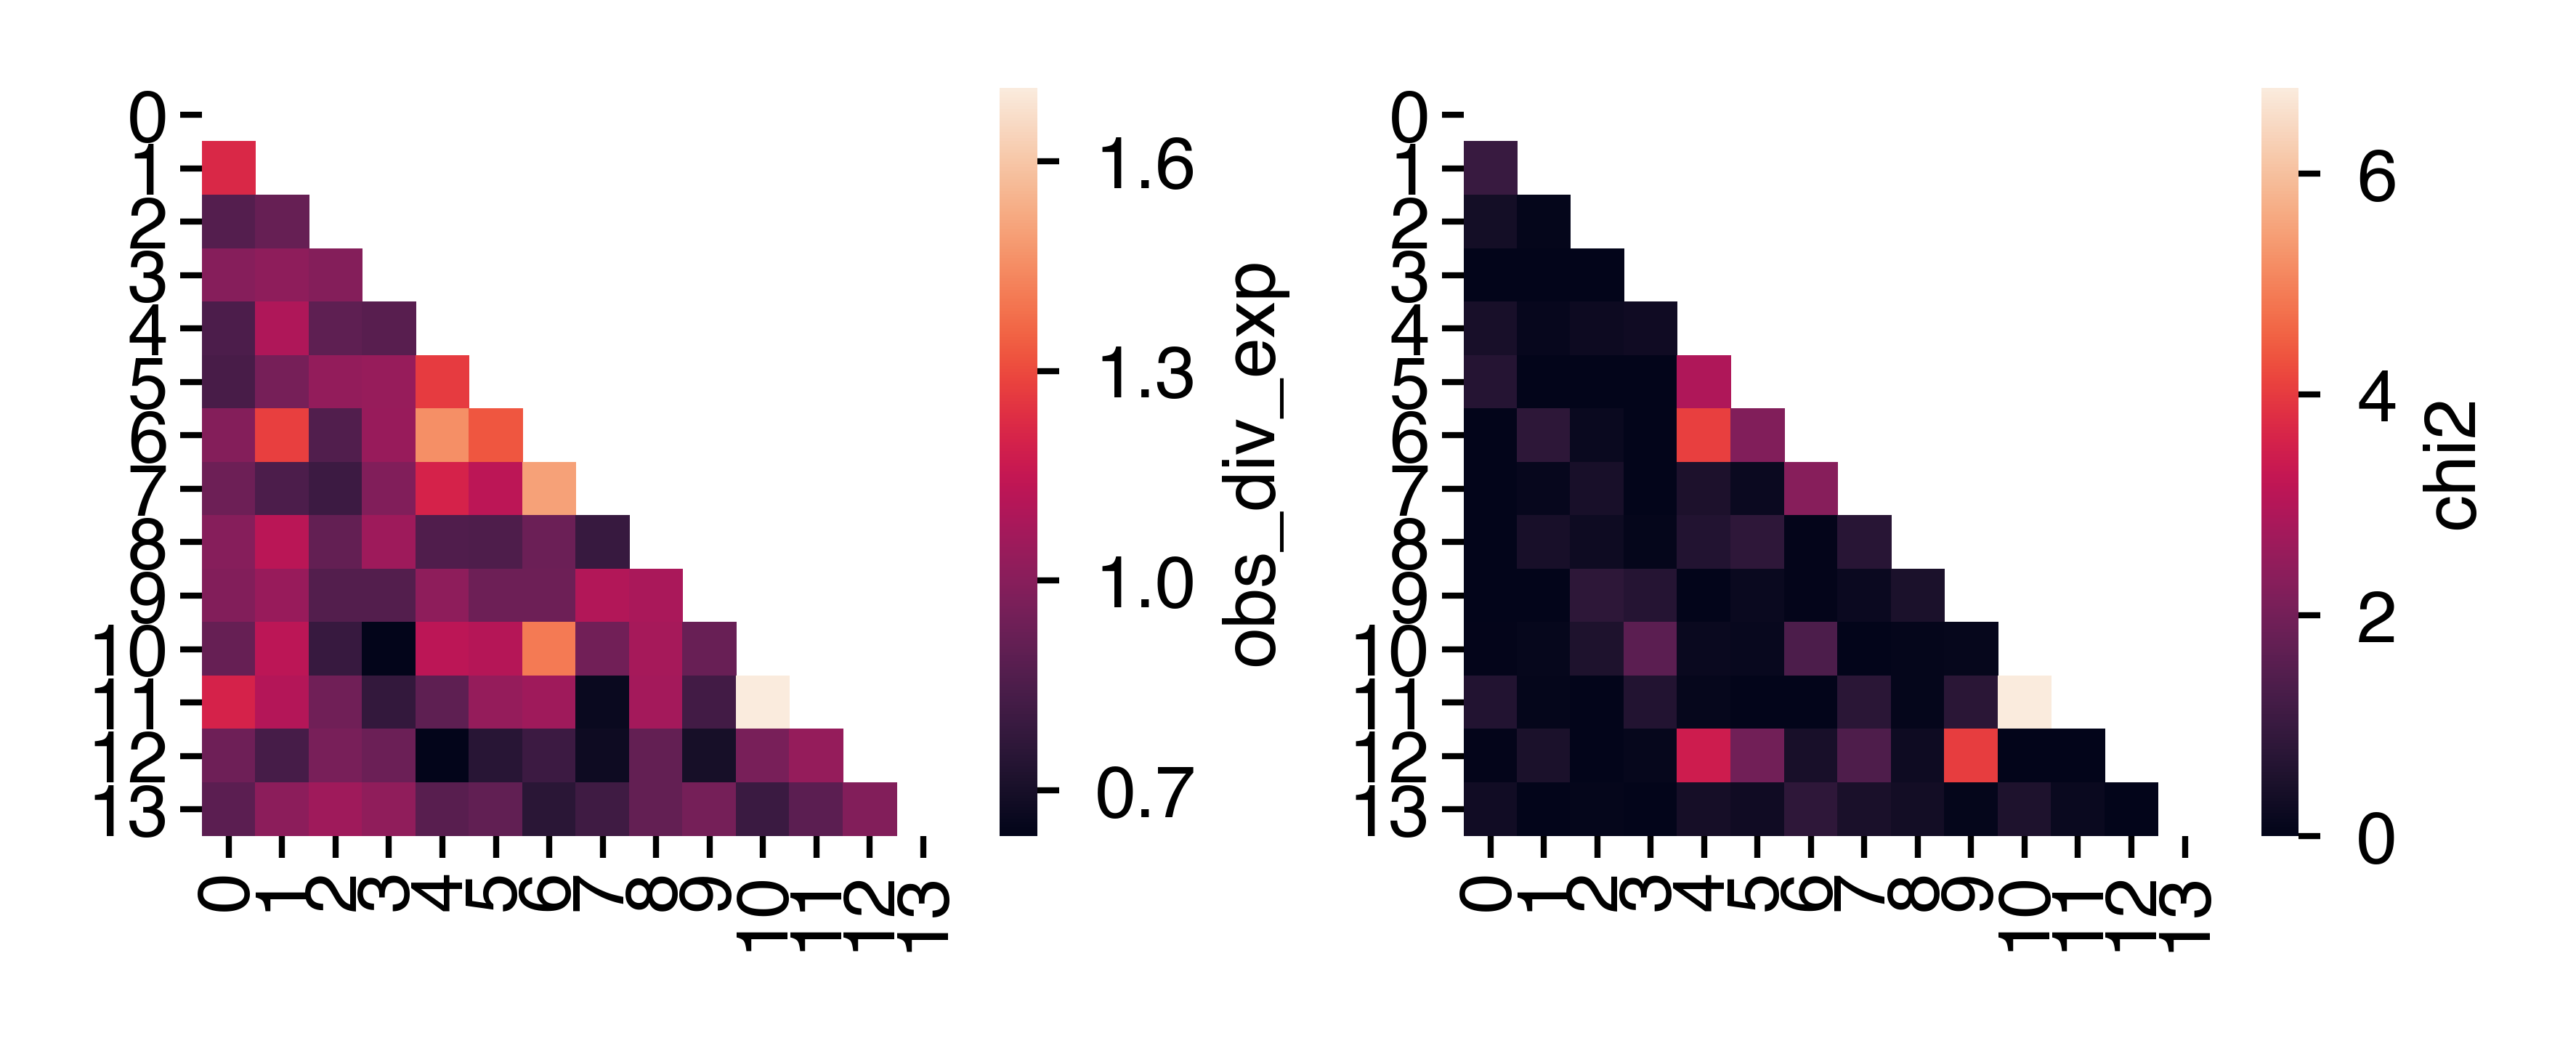

In [38]:
left_col = 'obs_div_exp'
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]/2.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
_cmap = ['#296eb4', '#e10600']
cbar_ticks = [0, 0.05, 0.1, 0.15, 0.2]
ticklength = 3
tickpad = 3
spine_lw = 0.5
spine_len = 1.8
labelpad = 2

# Get the behavioral matrix data to plot.
_gs_vars = ['Delay1-time', 'Delay2-time', 'Encoding-time', 'Retrieval-time',
            'Encoding-place', 'Retrieval-place', 'Encoding-head_direc', 'Retrieval-head_direc', 'Encoding-is_moving', 'Retrieval-is_moving',
            'Encoding-base_in_view', 'Retrieval-base_in_view', 'Encoding-gold_in_view', 'Retrieval-dig_performed']
qry = "(gameState1=='{}') & (testvar1=='{}') & (gameState2=='{}') & (testvar2=='{}')"
dat = {left_col : np.ones([len(gs_vars), len(gs_vars)]) * np.nan,
       'chi2'     : np.ones([len(gs_vars), len(gs_vars)]) * np.nan}
for ii in range(len(_gs_vars)):
    for jj in range(len(_gs_vars)):
        if ii <= jj:
            continue
        gs1, tv1 = _gs_vars[ii].split('-')
        gs2, tv2 = _gs_vars[jj].split('-')
        _df = overlap.query(qry.format(gs1, tv1, gs2, tv2))
        if len(_df) == 0:
            _df = overlap.query(qry.format(gs2, tv2, gs1, tv1))
        assert len(_df) == 1

        dat[left_col][ii, jj] = _df.iloc[0][left_col]
        if _df.iloc[0]['sig_fdr'] == True:
            dat['chi2'][ii, jj] = _df.iloc[0]['chi2']
        else:
            dat['chi2'][ii, jj] = _df.iloc[0]['chi2'] # 0
            
# Make the plots.
plt.close('')
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

# Plot the data.
for iax, col in enumerate([left_col, 'chi2']):
    if iax==0:
        vmin = overlap[col].min()
    else:
        vmin = overlap[col].min()
    vmax = overlap[col].max()
    print(vmin, vmax)
    
    ax[iax] = sns.heatmap(dat[col], vmin=vmin, vmax=vmax, square=True, ax=ax[iax],
                          cmap='rocket')
    col_labels = np.arange(len(_gs_vars))
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
    ax[iax].set_xticks(np.arange(0, len(col_labels), 1) + 0.5)
    ax[iax].set_xticklabels(col_labels, rotation=90)
    ax[iax].set_yticks(np.arange(0, len(col_labels), 1) + 0.5)
    ax[iax].set_yticklabels(col_labels, rotation=0)
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')
    
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    if col == left_col:
        cbar.set_ticks([0.7, 1, 1.3, 1.6])
        #cbar.set_clim([-10, 10])
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    elif col == 'chi2':
#         cbar.set_ticks([0, 5, 10, 15, 20, 25])
        cbar.set_clim([0, 7])
        cbar.set_ticks([0, 2, 4, 6])
    cbar.set_label(col, fontsize=font['tick'], labelpad=labelpad)
    
fig.tight_layout(w_pad=0)
print([(ii, _gs_vars[ii]) for ii in range(len(_gs_vars))])

if savefig:
    n_units = ols_pairs['subj_sess_unit'].unique().size
    filename = op.join(proj_dir, 'figs', 'plot_remapping', 'behavioral_response_overlap-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

Delay1-time Encoding-time


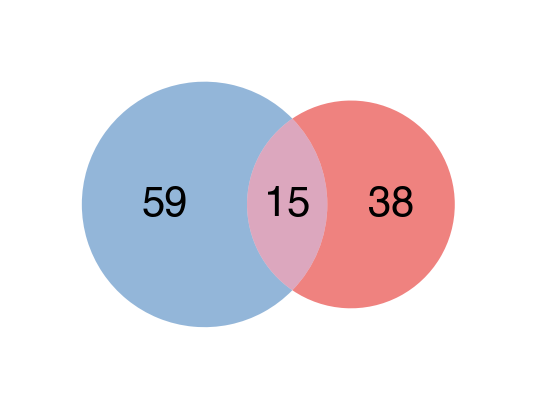

In [125]:
# Create Venn diagrams to show the overlap between
# game state x behavioral variable pairs.
savefig = 0
overwrite = 0
figsize = (colws[1], colws[1])
dpi = 1200
font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}
_cmap = ['#296eb4', '#e10600']
spine_lw = 0.5

# -------------------
pairs = [[list(sig_cells.keys())[ii], list(sig_cells.keys())[jj]]
         for ii in range(len(sig_cells))
         for jj in range(len(sig_cells))
         if (ii < jj)]

for idx, row in overlap.iterrows():
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=300)
    k1 = '{}-{}'.format(row['gameState1'], row['testvar1'])
    k2 = '{}-{}'.format(row['gameState2'], row['testvar2'])
    
    area = (row['sig1or2'] / n_cells)
    _venn = venn2([sig_cells[k1], sig_cells[k2]], normalize_to=area,
                   set_labels=None, set_colors=_cmap, alpha=0.5, ax=ax)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_color('k')
        ax.spines[axis].set_linewidth(spine_lw)

    if savefig:
        filename = op.join(proj_dir, 'figs', 'plot_remapping',
                           'venn_{}-{}units_{}-{}units.pdf'
                           .format(k1, len(sig_cells[k1]), k2, len(sig_cells[k2])))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
    
print(k1, k2)

fig.show()

In [6]:
ols_pairs.query("(full==['time', 'full'])").groupby(['gameState', 'testvar'], observed=True).agg({'sig': lambda x: '{}/{} ({:.1%})'.format(np.sum(x), len(x), np.mean(x))})

sig
gameState testvar                     
Delay1    time          73/457 (16.0%)
Encoding  time          88/457 (19.3%)
          place         71/457 (15.5%)
          head_direc    49/457 (10.7%)
          base_in_view   44/457 (9.6%)
          gold_in_view  88/457 (19.3%)
Delay2    time          63/457 (13.8%)
Retrieval time          80/457 (17.5%)
          place         84/457 (18.4%)
          head_direc    46/457 (10.1%)
          base_in_view  50/457 (10.9%)

In [24]:
ols_pairs.columns

Index(['subj', 'subj_sess', 'subj_sess_unit', 'neuron', 'hem', 'roi',
       'roi_gen2', 'roi_gen3', 'roi_gen4', 'roi_gen5', 'gameState', 'testvar',
       'full', 'llf_full', 'lr', 'z_lr', 'emp_pval', 'spike_mat', 'mean_frs',
       'sem_frs', 'fr_mean', 'fr_max', 'fr_max_ind', 'fr_max_ind4',
       'fr_max_ind5', 'fr_max_ind10', 'sparsity', 'sig', 'sig_holm',
       'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax',
       'beta_abs_max'],
      dtype='object')

In [25]:
all_cells = ols_pairs['subj_sess_unit'].unique()
qry = "(gameState==['Delay1', 'Delay2']) & (testvar=='time') & (sig==True) & (beta_abs_max>0)"
nav_time_cells = ols_pairs.query(qry)['subj_sess_unit'].unique()
nav_time_cells.size, all_cells.size, nav_time_cells.size / all_cells.size

(91, 457, 0.19912472647702406)

In [28]:
all_cells = ols_pairs['subj_sess_unit'].unique()
qry = "(gameState==['Encoding', 'Retrieval']) & (testvar=='time') & (sig==True) & (beta_abs_max>0)"
nav_time_cells = ols_pairs.query(qry)['subj_sess_unit'].unique()
nav_time_cells.size, all_cells.size, nav_time_cells.size / all_cells.size

(83, 457, 0.18161925601750548)

In [32]:
all_cells = ols_pairs['subj_sess_unit'].unique()
qry = "(gameState==['Delay1', 'Encoding', 'Delay2', 'Retrieval']) & (testvar=='time') & (sig==True) & (beta_abs_max>0)"
nav_time_cells = ols_pairs.query(qry)['subj_sess_unit'].unique()
nav_time_cells.size, all_cells.size, nav_time_cells.size / all_cells.size

(155, 457, 0.33916849015317285)

In [ ]:
# Determine which time cells significantly remapped between Encoding and Retrieval
# by comparing the mean difference in firing rate correlation between
# within-interval vs. between-inteval trial pairs.
sim_func = 'pearson'
n_perm = 1000
alpha = 0.05
save_output = True
overwrite = True
game_state_pairs = [('Delay1',   'Delay2',    'prop'),
                    ('Encoding', 'Retrieval', 'prop'),
                    ('Delay1',   'Encoding',  'first10'),
                    ('Delay1',   'Retrieval', 'first10'),
                    ('Delay1',   'Encoding',  'last10'),
                    ('Delay1',   'Retrieval', 'last10'),
                    ('Delay1',   'Encoding',  'prop'),
                    ('Delay1',   'Retrieval', 'prop'),
                    ('Encoding', 'Delay2',    'first10'),
                    ('Delay2',   'Retrieval', 'first10'),
                    ('Encoding', 'Delay2',    'last10'),
                    ('Delay2',   'Retrieval', 'last10'),
                    ('Encoding', 'Delay2',    'prop'),
                    ('Delay2',   'Retrieval', 'prop')]

start_time = time()
warnings.filterwarnings('ignore')

time_remapping = []    
# Calculate remapping scores for each contrast between intervals.
for (gs1, gs2, contrast) in game_state_pairs:
    qry = "(gameState==['{}', '{}']) & (testvar=='time') & (sig==True) & (beta_abs_max>0)".format(gs1, gs2)
    _time_cells = ols_pairs.query(qry)['subj_sess_unit'].unique().tolist()
    qry = "(gameState==['{}', '{}']) & (testvar=='time') & (subj_sess_unit=={})".format(gs1, gs2, _time_cells)
    grp = (ols_pairs.sort_values(['subj_sess', 'neuron', 'gameState'])
           .query(qry)
           .groupby(['subj_sess_unit'], observed=True))

    for neuron, _df in grp:
        assert len(_df) == 2
        assert _df.iloc[0]['gameState'] == gs1
        assert _df.iloc[1]['gameState'] == gs2
        subj_sess = _df.iloc[0]['subj_sess']
        nsig = np.sum(_df['sig'].astype(int) * (_df['beta_abs_max'] > 0).astype(int))
        assert nsig in [1, 2]

        # Load event_spikes.
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
        elif event_spikes.subj_sess != subj_sess:
            event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
        
        spike_mats = od([])
        for _, row in _df.iterrows():
            spike_mats[row['gameState']] = event_spikes.get_spike_mat(row['neuron'], row['gameState'], column='time_bin')
            
            # Aggregate time bins.
            if ('Delay' in row['gameState']) or (contrast == 'prop'):
                spike_mats[row['gameState']] = np.array([np.mean(x, axis=-1) for x in np.split(spike_mats[row['gameState']].values, 10, axis=1)]).T
            else:
                if contrast == 'first10':
                    spike_mats[row['gameState']] = np.array([np.mean(x, axis=-1) for x in np.split(spike_mats[row['gameState']].values, 30, axis=1)]).T[:, :10]
                elif contrast == 'last10':
                    spike_mats[row['gameState']] = np.array([np.mean(x, axis=-1) for x in np.split(spike_mats[row['gameState']].values, 30, axis=1)]).T[:, -10:]
        
        # Get firing vector correlations between trial pairs.
        pairwise_sims = remapping.trial_pair_remapping(spike_mats, sim_func=sim_func)
        mean_sims = {k : np.mean(v) for k, v in pairwise_sims.items()}
        mean_sims['within'] = np.max((mean_sims[gs1], mean_sims[gs2]))
        asym = mean_sims['within'] - mean_sims['between']
        
        # Compute the null distribution.
        pairwise_sims_vec = np.concatenate([pairwise_sims[gs1],
                                            pairwise_sims[gs2],
                                            pairwise_sims['between']]) # cond x trial_pair
        divs = np.cumsum((len(pairwise_sims[gs1]), len(pairwise_sims[gs2]), len(pairwise_sims['between'])))[:2]
        within_sims_null = []
        btwn_sims_null = []
        asyms_null = []
        for iPerm in range(n_perm):
            np.random.shuffle(pairwise_sims_vec)
            mean_sims_null = dict(zip([gs1, gs2, 'between'], 
                                      [np.mean(x) for x in np.split(pairwise_sims_vec, divs)]))
            mean_sims_null['within'] = np.max((mean_sims_null[gs1], mean_sims_null[gs2]))
            within_sims_null.append(mean_sims_null['within'])
            btwn_sims_null.append(mean_sims_null['between'])
            asyms_null.append(mean_sims_null['within'] - mean_sims_null['between'])
        within_sims_null = np.array(within_sims_null)
        btwn_sims_null = np.array(btwn_sims_null)
        asyms_null = np.array(asyms_null)
        
        asym_z = (asym - np.mean(asyms_null)) / np.std(asyms_null)
        if asym_z > 0:
            asym_z_sign = 1
        elif asym_z == 0:
            asym_z_sign = 0
        else:
            asym_z_sign = -1
        pval_ind = np.sum(np.abs(asyms_null) >= np.abs(asym))
        pval = (1 + pval_ind) / (1 + n_perm)

        # Figure out which trial interval has stronger time coding.
        # (If only one trial phase is significant, take that one. Otherwise, take whichever
        # has the highest info score). Then add time coding info for the stronger trial phase.
        z_lr_diff = np.abs(np.diff(_df['z_lr']))[0]
        if nsig == 1:
            row = _df.query("(sig==True)").iloc[0]
        else:
            row = _df.sort_values('z_lr', ascending=False).iloc[0]
        main_game_state = row['gameState']
        z_lr = row['z_lr']
        fr_max_ind = row['fr_max_ind']
        time_remapping.append([neuron, subj_sess, gs1, gs2, contrast,
                               nsig, z_lr_diff, main_game_state, z_lr, fr_max_ind,
                               mean_sims['within'], mean_sims['between'],
                               asym, asym_z, asym_z_sign, pval_ind, pval])
    
time_remapping = pd.DataFrame(time_remapping, columns=['neuron', 'subj_sess', 'gameState1', 'gameState2', 'contrast',
                                                       'nsig',   'z_lr_diff', 'main_game_state', 'z_lr', 'fr_max_ind',
                                                       'r_within', 'r_btwn',
                                                       'asym', 'asym_z', 'asym_z_sign', 'pval_ind', 'pval'])
time_remapping['sig'] = time_remapping['pval'] < alpha
time_remapping['asym_z_cat'] = 0
time_remapping.loc[(time_remapping['sig']==True) & (time_remapping['asym_z_sign']==-1), 'asym_z_cat'] = 1
time_remapping.loc[(time_remapping['sig']==True) & (time_remapping['asym_z_sign']==1), 'asym_z_cat'] = 2
time_remapping['dummy'] = 0
unit_to_roi_map = ols_pairs[['subj_sess_unit', 'roi_gen5']].drop_duplicates().set_index('subj_sess_unit')['roi_gen5'].to_dict()
time_remapping.insert(2, 'roi_gen5', time_remapping['neuron'].apply(lambda x: unit_to_roi_map[x]))

if save_output:
    filename = op.join(proj_dir, 'analysis', 'remapping',
                       'time_remapping_{}time_cells_{}neurons.pkl'
                       .format(time_remapping['neuron'].unique().size, ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        dio.save_pickle(time_remapping, filename)

warnings.resetwarnings()
print('time_remapping: {}'.format(time_remapping.shape))
print('Dont in {:.1f}s'.format(time() - start_time))

In [128]:
# max(within)
def sum_pct(x):
    return '{}/{} ({:.1%})'.format(np.sum(x), x.size, np.sum(x) / len(x))

def mean_sem(x):
    return '{:.2f} ± {:.2f}'.format(np.mean(x), stats.sem(x))

sig_pct = time_remapping.groupby(['gameState1', 'gameState2', 'contrast']).agg({'sig': sum_pct,
                                                                      'r_within': mean_sem,
                                                                      'r_btwn': mean_sem,
                                                                      'asym_z': mean_sem,
                                                                      'nsig': lambda x: np.unique(x, return_counts=True)})

In [127]:
# max(within)
def sum_pct(x):
    return '{}/{} ({:.1%})'.format(np.sum(x), x.size, np.sum(x) / len(x))

def mean_sem(x):
    return '{:.2f} ± {:.2f}'.format(np.mean(x), stats.sem(x))

(time_remapping
 .query("(sig==True)")
 .groupby(['gameState1', 'gameState2', 'contrast'])
 .agg({'sig': sum_pct,
       'r_within': mean_sem,
       'r_btwn': mean_sem,
       'asym_z': mean_sem,
       'asym_z_sign': lambda x: np.unique(x, return_counts=True),
       'nsig': lambda x: np.unique(x, return_counts=True),
       'main_game_state': lambda x: np.unique(x, return_counts=True)}))

sig     r_within        r_btwn  \
gameState1 gameState2 contrast                                              
Delay1     Delay2     prop      19/19 (100.0%)  0.05 ± 0.01  -0.00 ± 0.00   
           Encoding   first10   52/52 (100.0%)  0.09 ± 0.01  -0.01 ± 0.00   
                      last10    29/29 (100.0%)  0.06 ± 0.01  -0.02 ± 0.00   
                      prop      74/74 (100.0%)  0.09 ± 0.01  -0.01 ± 0.00   
           Retrieval  first10   43/43 (100.0%)  0.08 ± 0.01  -0.02 ± 0.00   
                      last10    30/30 (100.0%)  0.06 ± 0.01  -0.01 ± 0.00   
                      prop      58/58 (100.0%)  0.09 ± 0.01  -0.01 ± 0.00   
Delay2     Retrieval  first10   42/42 (100.0%)  0.08 ± 0.01  -0.02 ± 0.00   
                      last10    32/32 (100.0%)  0.06 ± 0.01  -0.01 ± 0.00   
                      prop      53/53 (100.0%)  0.09 ± 0.01  -0.00 ± 0.01   
Encoding   Delay2     first10   46/46 (100.0%)  0.09 ± 0.01  -0.01 ± 0.01   
                      last10    32/32 (100.0%)  0.06 ± 0.01  -0.01 ± 0.00   
                      prop      67/67 (100.0%)  0.09 ± 0.01  -0.02 ± 0.00   
           Retrieval  prop      39/39 (100.0%)  0.12 ± 0.01   0.03 ± 0.01   

                                     asym_z         asym_z_sign  \
gameState1 gameState2 contrast                                    
Delay1     Delay2     prop      2.58 ± 0.24         ([1], [19])   
           Encoding   first10   4.87 ± 0.47         ([1], [52])   
                      last10    3.65 ± 0.39         ([1], [29])   
                      prop      4.78 ± 0.38         ([1], [74])   
           Retrieval  first10   4.94 ± 0.56         ([1], [43])   
                      last10    3.38 ± 0.42         ([1], [30])   
                      prop      4.43 ± 0.31  ([-1, 1], [1, 57])   
Delay2     Retrieval  first10   4.77 ± 0.60         ([1], [42])   
                      last10    3.10 ± 0.40  ([-1, 1], [1, 31])   
                      prop      4.54 ± 0.30         ([1], [53])   
Encoding   Delay2     first10   4.93 ± 0.55         ([1], [46])   
                      last10    3.35 ± 0.29         ([1], [32])   
                      prop      4.90 ± 0.36         ([1], [67])   
           Retrieval  prop      4.32 ± 0.44         ([1], [39])   

                                             nsig  \
gameState1 gameState2 contrast                      
Delay1     Delay2     prop      ([1, 2], [18, 1])   
           Encoding   first10   ([1, 2], [46, 6])   
                      last10    ([1, 2], [28, 1])   
                      prop      ([1, 2], [67, 7])   
           Retrieval  first10   ([1, 2], [37, 6])   
                      last10    ([1, 2], [26, 4])   
                      prop      ([1, 2], [52, 6])   
Delay2     Retrieval  first10   ([1, 2], [39, 3])   
                      last10    ([1, 2], [28, 4])   
                      prop      ([1, 2], [49, 4])   
Encoding   Delay2     first10   ([1, 2], [41, 5])   
                      last10    ([1, 2], [29, 3])   
                      prop      ([1, 2], [62, 5])   
           Retrieval  prop      ([1, 2], [31, 8])   

                                                  main_game_state  
gameState1 gameState2 contrast                                     
Delay1     Delay2     prop            ([Delay1, Delay2], [11, 8])  
           Encoding   first10      ([Delay1, Encoding], [32, 20])  
                      last10        ([Delay1, Encoding], [23, 6])  
                      prop         ([Delay1, Encoding], [39, 35])  
           Retrieval  first10     ([Delay1, Retrieval], [31, 12])  
                      last10       ([Delay1, Retrieval], [25, 5])  
                      prop        ([Delay1, Retrieval], [37, 21])  
Delay2     Retrieval  first10     ([Delay2, Retrieval], [30, 12])  
                      last10       ([Delay2, Retrieval], [24, 8])  
                      prop        ([Delay2, Retrieval], [27, 26])  
Encoding   Delay2     first10      ([Delay2, Encoding], [21, 25])  
    

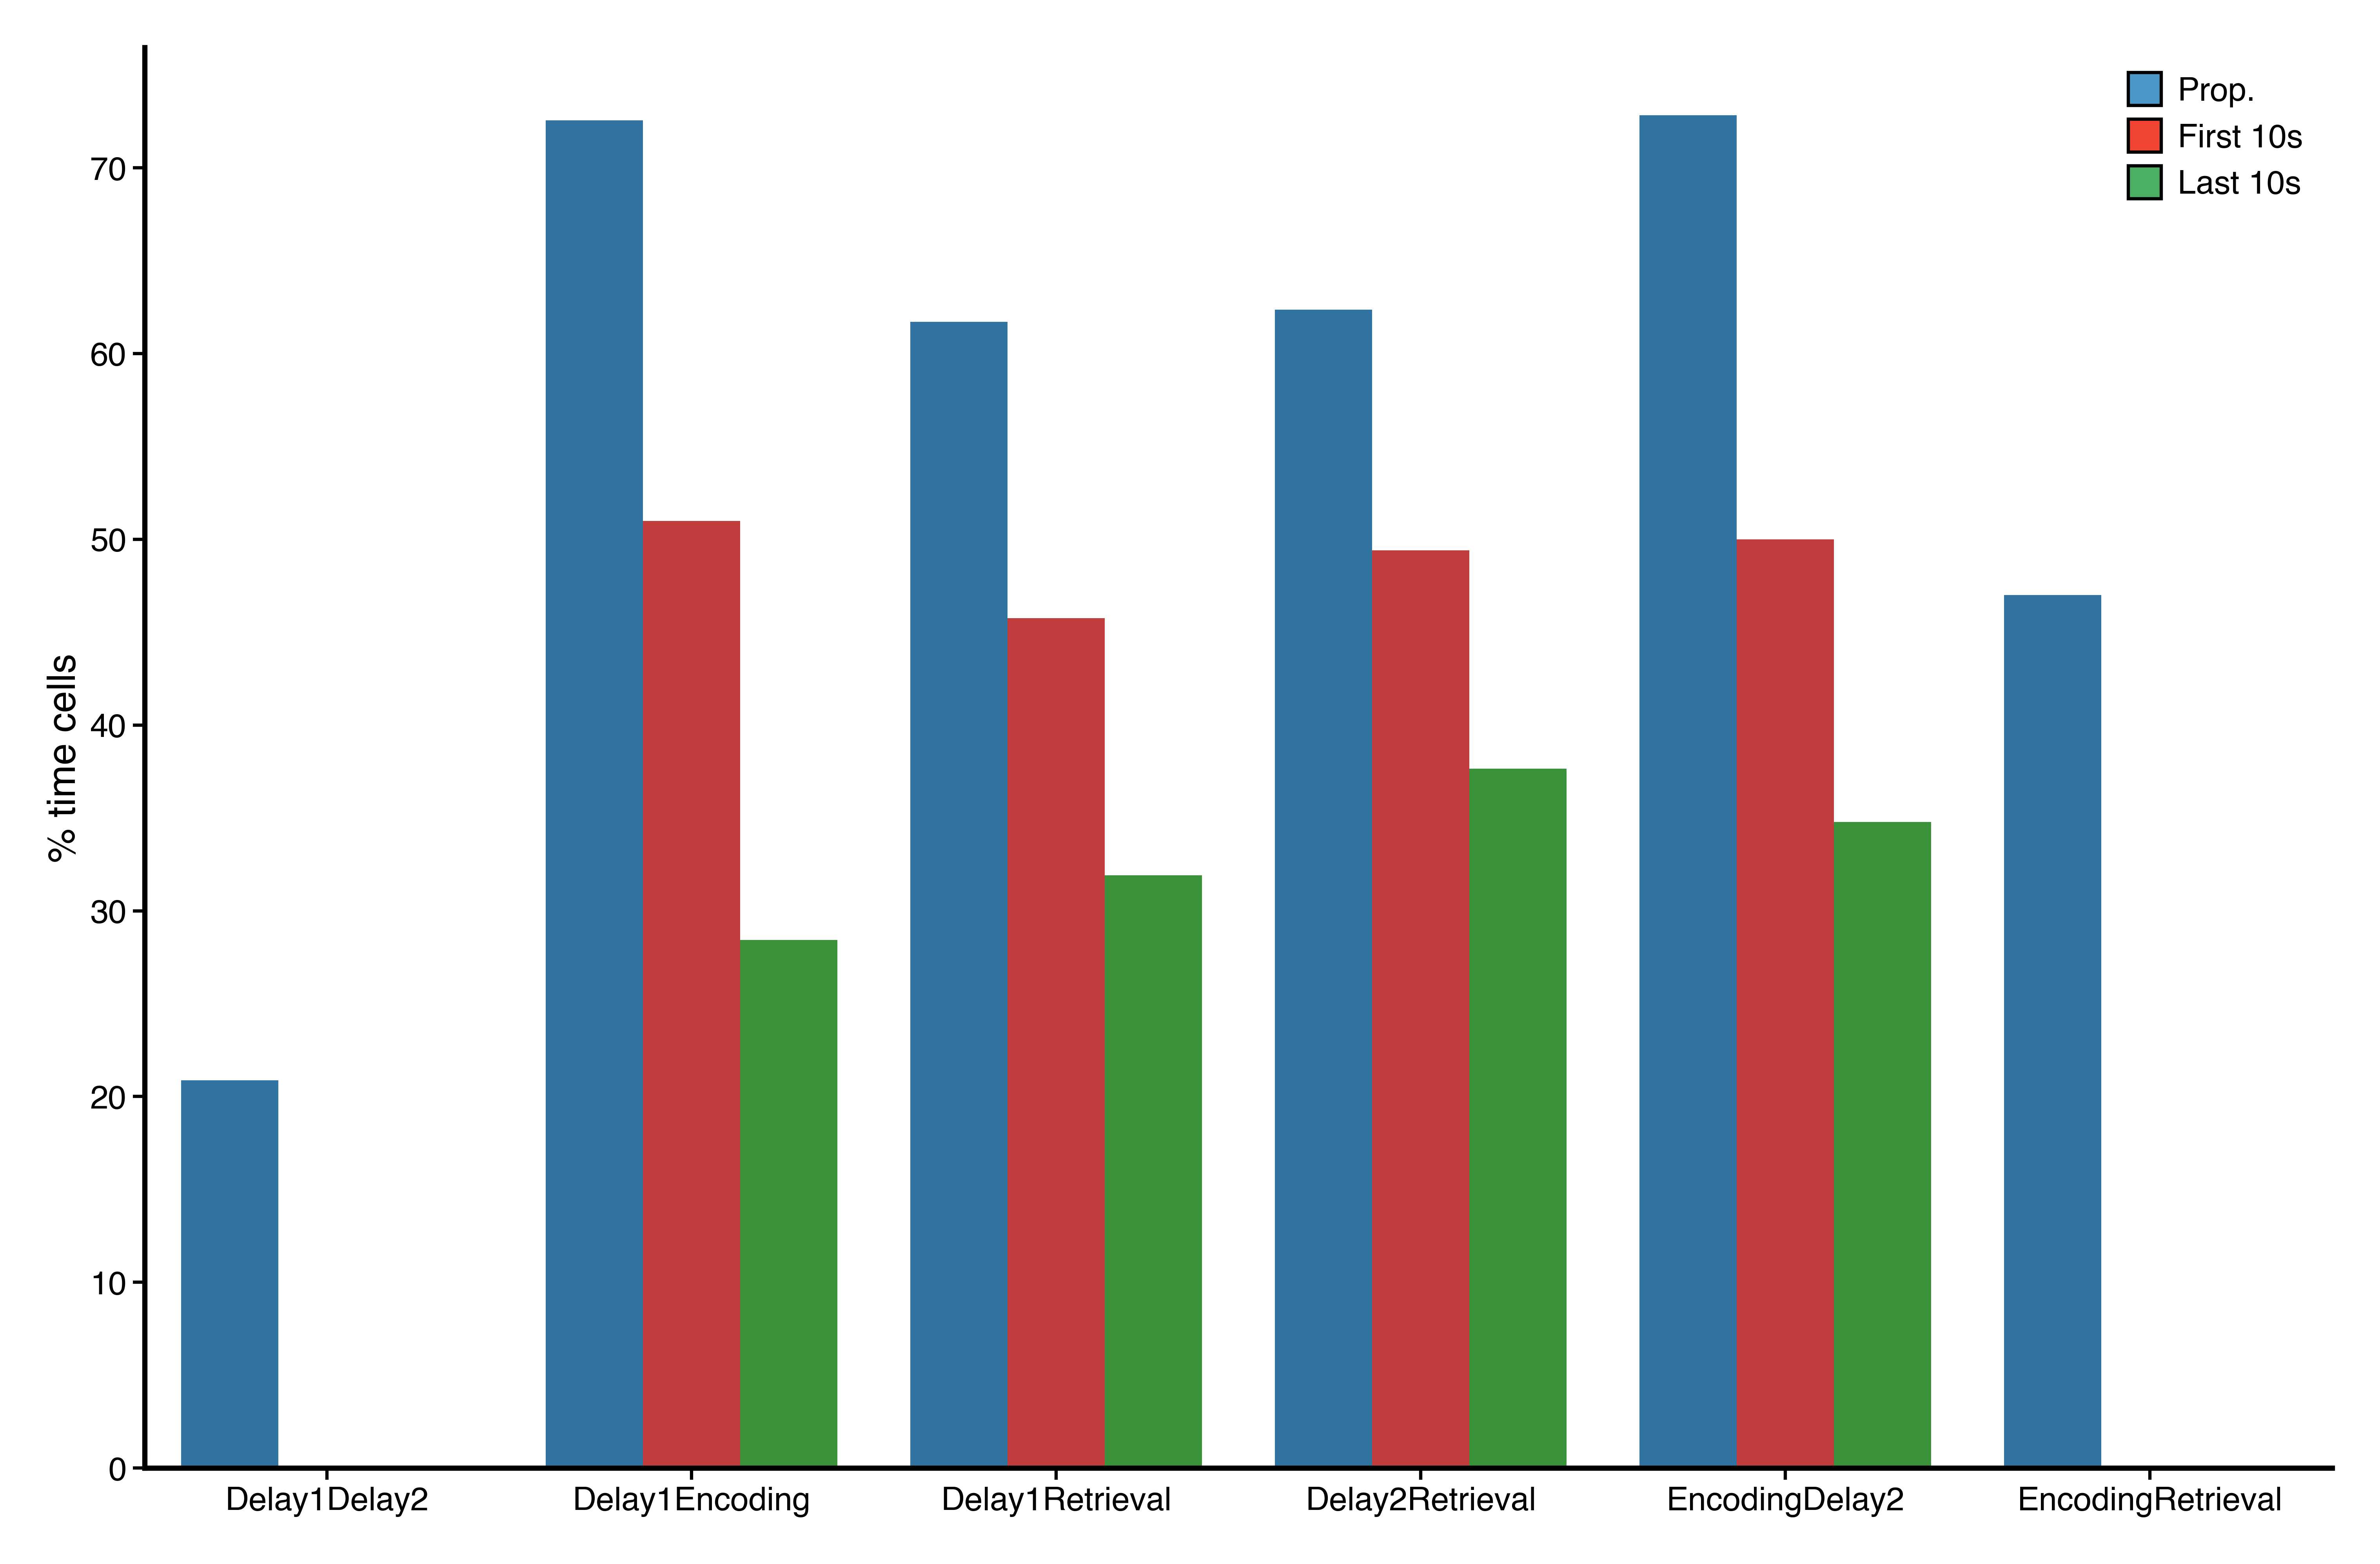

In [142]:
fig, ax = plt.subplots(1, 1, dpi=1200)
ax = np.ravel(ax)

sig_pct['gameStates'] = sig_pct['gameState1'] + sig_pct['gameState2']

iax = 0
ax[iax] = sns.barplot(x='gameStates', y='sig', hue='contrast', data=sig_pct, ax=ax[iax])
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xlabel('')
ax[iax].set_ylabel('% time cells', fontsize=font['label'], labelpad=labelpad-1)

ax[iax].get_legend().remove()
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Prop.', mfc=colors[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='First 10s', mfc=colors[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='Last 10s', mfc=colors[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], bbox_to_anchor=(1, 1), handletextpad=0)


In [129]:
savefig = 0
overwrite = 0
sig_col = 'sig_pos'
test_vars = ['time', 'place', 'head_direc', 'base_in_view', 'gold_in_view']
xcats = ['Time', 'Place', 'Head\ndirec.', 'View\nbase', 'View\ngold']
ylim = [0, 15]
yticks = [0, 5, 10, 15]
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)

# Graph percent of units that code for each variable of interest.
sig_pct = time_remapping.groupby(['gameState1', 'gameState2', 'contrast']).agg({'sig': lambda x: 100 * np.mean(x)}).reset_index()

#sig_pct.columns = ['gameState', 'testvar', 'sum', 'pct']
sig_pct['gameState'] = sig_pct['gameState'].astype(str)

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='testvar', y='pct', hue='gameState', data=sig_pct, ax=ax,
                 palette=['k', cmap[0]], saturation=1, linewidth=spine_lw, edgecolor='k')
ax.hlines(2.5, -0.5, 4.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

# ax2 = ax.twinx()
# ax2.spines['right'].set_visible(True)
# ax2.spines['right'].set_linewidth(spine_lw)
# for axis in ['left', 'bottom', 'top']:
#     ax2.spines[axis].set_visible(False)
# ax2.tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
# slope, icpt, *_ = stats.linregress(sig_pct['pct'], sig_pct['sum'])
# ax2.set_ylim(icpt + (np.array(ylim) * slope))
# ax2.set_yticks(icpt + (np.array(yticks)*slope))
# ax2.set_yticklabels(np.rint(icpt + (np.array(yticks)*slope)).astype(int))
# ax2.set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)

ax.get_legend().remove()
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Encoding', mfc='k', mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='Retrieval', mfc=cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax.legend(handles=custom_lines, fontsize=font['annot'], bbox_to_anchor=(0.33, 1.08), handletextpad=0)

if savefig:
    n_units = np.unique(ols_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'pct_sig-time_place_hd_gold_base-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

KeyError: 'gameState'

In [118]:
# mean(within)
def sum_pct(x):
    return '{}/{} ({:.1%})'.format(np.sum(x), x.size, np.sum(x) / len(x))

time_remapping.groupby(['gameState1', 'gameState2', 'contrast']).agg({'sig': sum_pct})

sig
gameState1 gameState2 contrast                
Delay1     Delay2     prop         8/91 (8.8%)
           Encoding   first10   37/102 (36.3%)
                      last10    21/102 (20.6%)
                      prop      51/102 (50.0%)
           Retrieval  first10    32/94 (34.0%)
                      last10     16/94 (17.0%)
                      prop       43/94 (45.7%)
Delay2     Retrieval  first10    40/85 (47.1%)
                      last10     17/85 (20.0%)
                      prop       40/85 (47.1%)
Encoding   Delay2     first10    35/92 (38.0%)
                      last10     21/92 (22.8%)
                      prop       52/92 (56.5%)
           Retrieval  prop       24/83 (28.9%)

In [41]:
print(stats.pearsonr(time_remapping['z_lr'], time_remapping['asym_z']))
time_remapping.groupby('asym_z_cat').agg({'neuron': len, 'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))})

(0.3080394790379674, 0.0002134481075753917)


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,neuron,z_lr
asym_z_cat,,
0,71,3.3 ± 0.2
1,1,2.3 ± nan
2,68,3.7 ± 0.2


In [44]:
print(stats.pearsonr(time_remapping['z_lr'], time_remapping['asym_z']))
time_remapping.query("(nsig==2)").groupby('asym_z_cat').agg({'neuron': len, 'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), stats.sem(x))})

(0.3080394790379674, 0.0002134481075753917)


,neuron,z_lr
asym_z_cat,,
0,9,4.7 ± 0.4
2,13,4.7 ± 0.7


In [45]:
time_remapping.groupby(['nsig', 'roi_gen'])['asym_z_cat'].apply(lambda x: '{}/{}; {:.1%}'.format(np.sum(x==2), len(x), np.mean(x==2)))

nsig  roi_gen    
1     Cortex         19/41; 46.3%
      Hippocampus     7/20; 35.0%
      MTL            29/57; 50.9%
2     Cortex         10/17; 58.8%
      Hippocampus      1/2; 50.0%
      MTL              2/3; 66.7%
Name: asym_z_cat, dtype: object

In [46]:
time_remapping['_fr_max_ind'] = np.floor(time_remapping['fr_max_ind'] / 12)
time_remapping.groupby('_fr_max_ind')['asym_z_cat'].apply(lambda x: '{}/{}; {:.1%}'.format(np.sum(x==2), len(x), np.mean(x==2)))

_fr_max_ind
0.0    27/50; 54.0%
1.0     7/16; 43.8%
2.0     5/20; 25.0%
3.0    15/28; 53.6%
4.0    14/26; 53.8%
Name: asym_z_cat, dtype: object

In [49]:
time_remapping.groupby(['asym_z_cat']).agg({'neuron': len, 'fr_max_ind': [np.mean, np.std, stats.sem]})

neuron fr_max_ind                     
              len       mean        std       sem
asym_z_cat                                       
0              23  21.913043  18.644797  3.887709
2              51  25.960784  20.664908  2.893666

In [47]:
time_remapping.groupby('nsig').agg({'neuron': lambda x: '{}/{} ({:.1%})'.format(len(x), all_cells.size, len(x)/all_cells.size)})

,neuron
nsig,
1,118/433 (27.3%)
2,22/433 (5.1%)


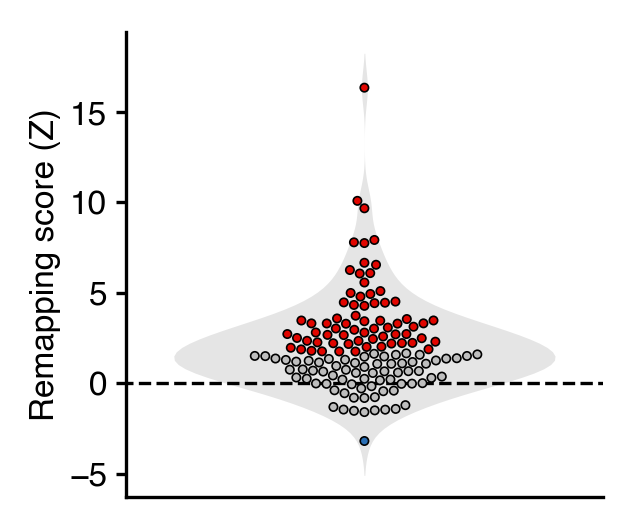

In [51]:
savefig = 0
overwrite = 1

fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=300)
#ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}
_cmap = ['#bebebe', '#296eb4', '#e10600']

i = 0
ax = sns.violinplot(x='dummy', y='asym_z', data=time_remapping, ax=ax,
                    inner=None, color='k',  saturation=100, zorder=0)

poly = ax.collections[0]
poly.set_alpha(0.1)
poly.set_linewidth(0)
ax = sns.swarmplot(x='dummy', y='asym_z', hue='asym_z_cat', data=time_remapping,
                   palette=_cmap, size=2, edgecolor='k', linewidth=0.4, zorder=2, ax=ax)
ax.get_legend().remove()
ax.tick_params(axis='y', which='both', length=2.5, pad=2, labelsize=font['tick'])
ax.set_xlim([-0.5, 0.5])
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Remapping score (Z)', fontsize=font['label'], labelpad=2)
plt.hlines(0, -10, 10, color='k', linewidth=0.8, linestyle='--', zorder=1)

if savefig:
    n_neurons = time_remapping['neuron'].unique().size
    filename = op.join(proj_dir, 'figs', 'plot_remapping',
                       'nav_time_cell_remapping_scores-{}units.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

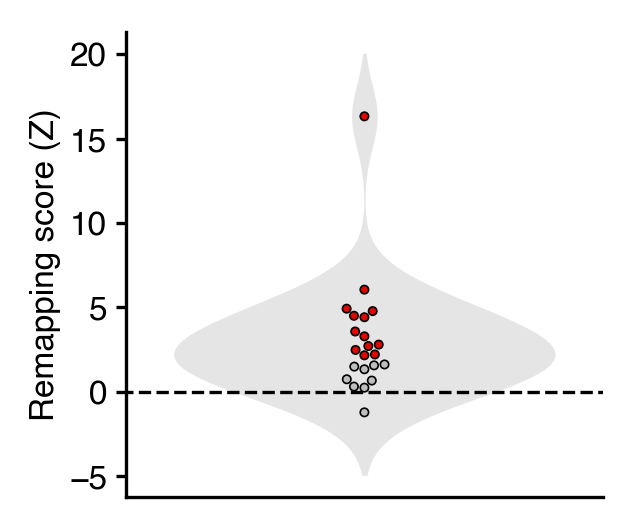

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=300)
#ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 10}
_cmap = ['#bebebe', '#e10600'] # ['#bebebe', '#296eb4', '#e10600']
_df = time_remapping.query("(nsig==2)")

i = 0
ax = sns.violinplot(x='dummy', y='asym_z', data=_df,
                    inner=None, color='k',  saturation=100, zorder=0, ax=ax)

poly = ax.collections[0]
poly.set_alpha(0.1)
poly.set_linewidth(0)
ax = sns.swarmplot(x='dummy', y='asym_z', hue='asym_z_cat', data=_df,
                   palette=_cmap, size=2, 
                   edgecolor='k', linewidth=0.4, zorder=2, ax=ax)
ax.get_legend().remove()
ax.tick_params(axis='y', which='both', length=2.5, pad=2, labelsize=font['tick'])
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Remapping score (Z)', fontsize=font['label'], labelpad=2)
plt.hlines(0, -10, 10, color='k', linewidth=0.8, linestyle='--', zorder=1)

fig.show()

In [80]:
print(time_remapping.sort_values('asym_z', ascending=False).groupby('sig').size())
print('{:.2f} ± {:.2f}, n = {}'.format(np.mean(time_remapping['asym_z']), stats.sem(time_remapping['asym_z']), len(time_remapping['asym_z'])))
print(stats.ttest_1samp(time_remapping['asym_z'], 0))

sig
False    23
True     51
dtype: int64
3.28 ± 0.35, n = 74
Ttest_1sampResult(statistic=9.349438287630713, pvalue=4.1309707115069946e-14)


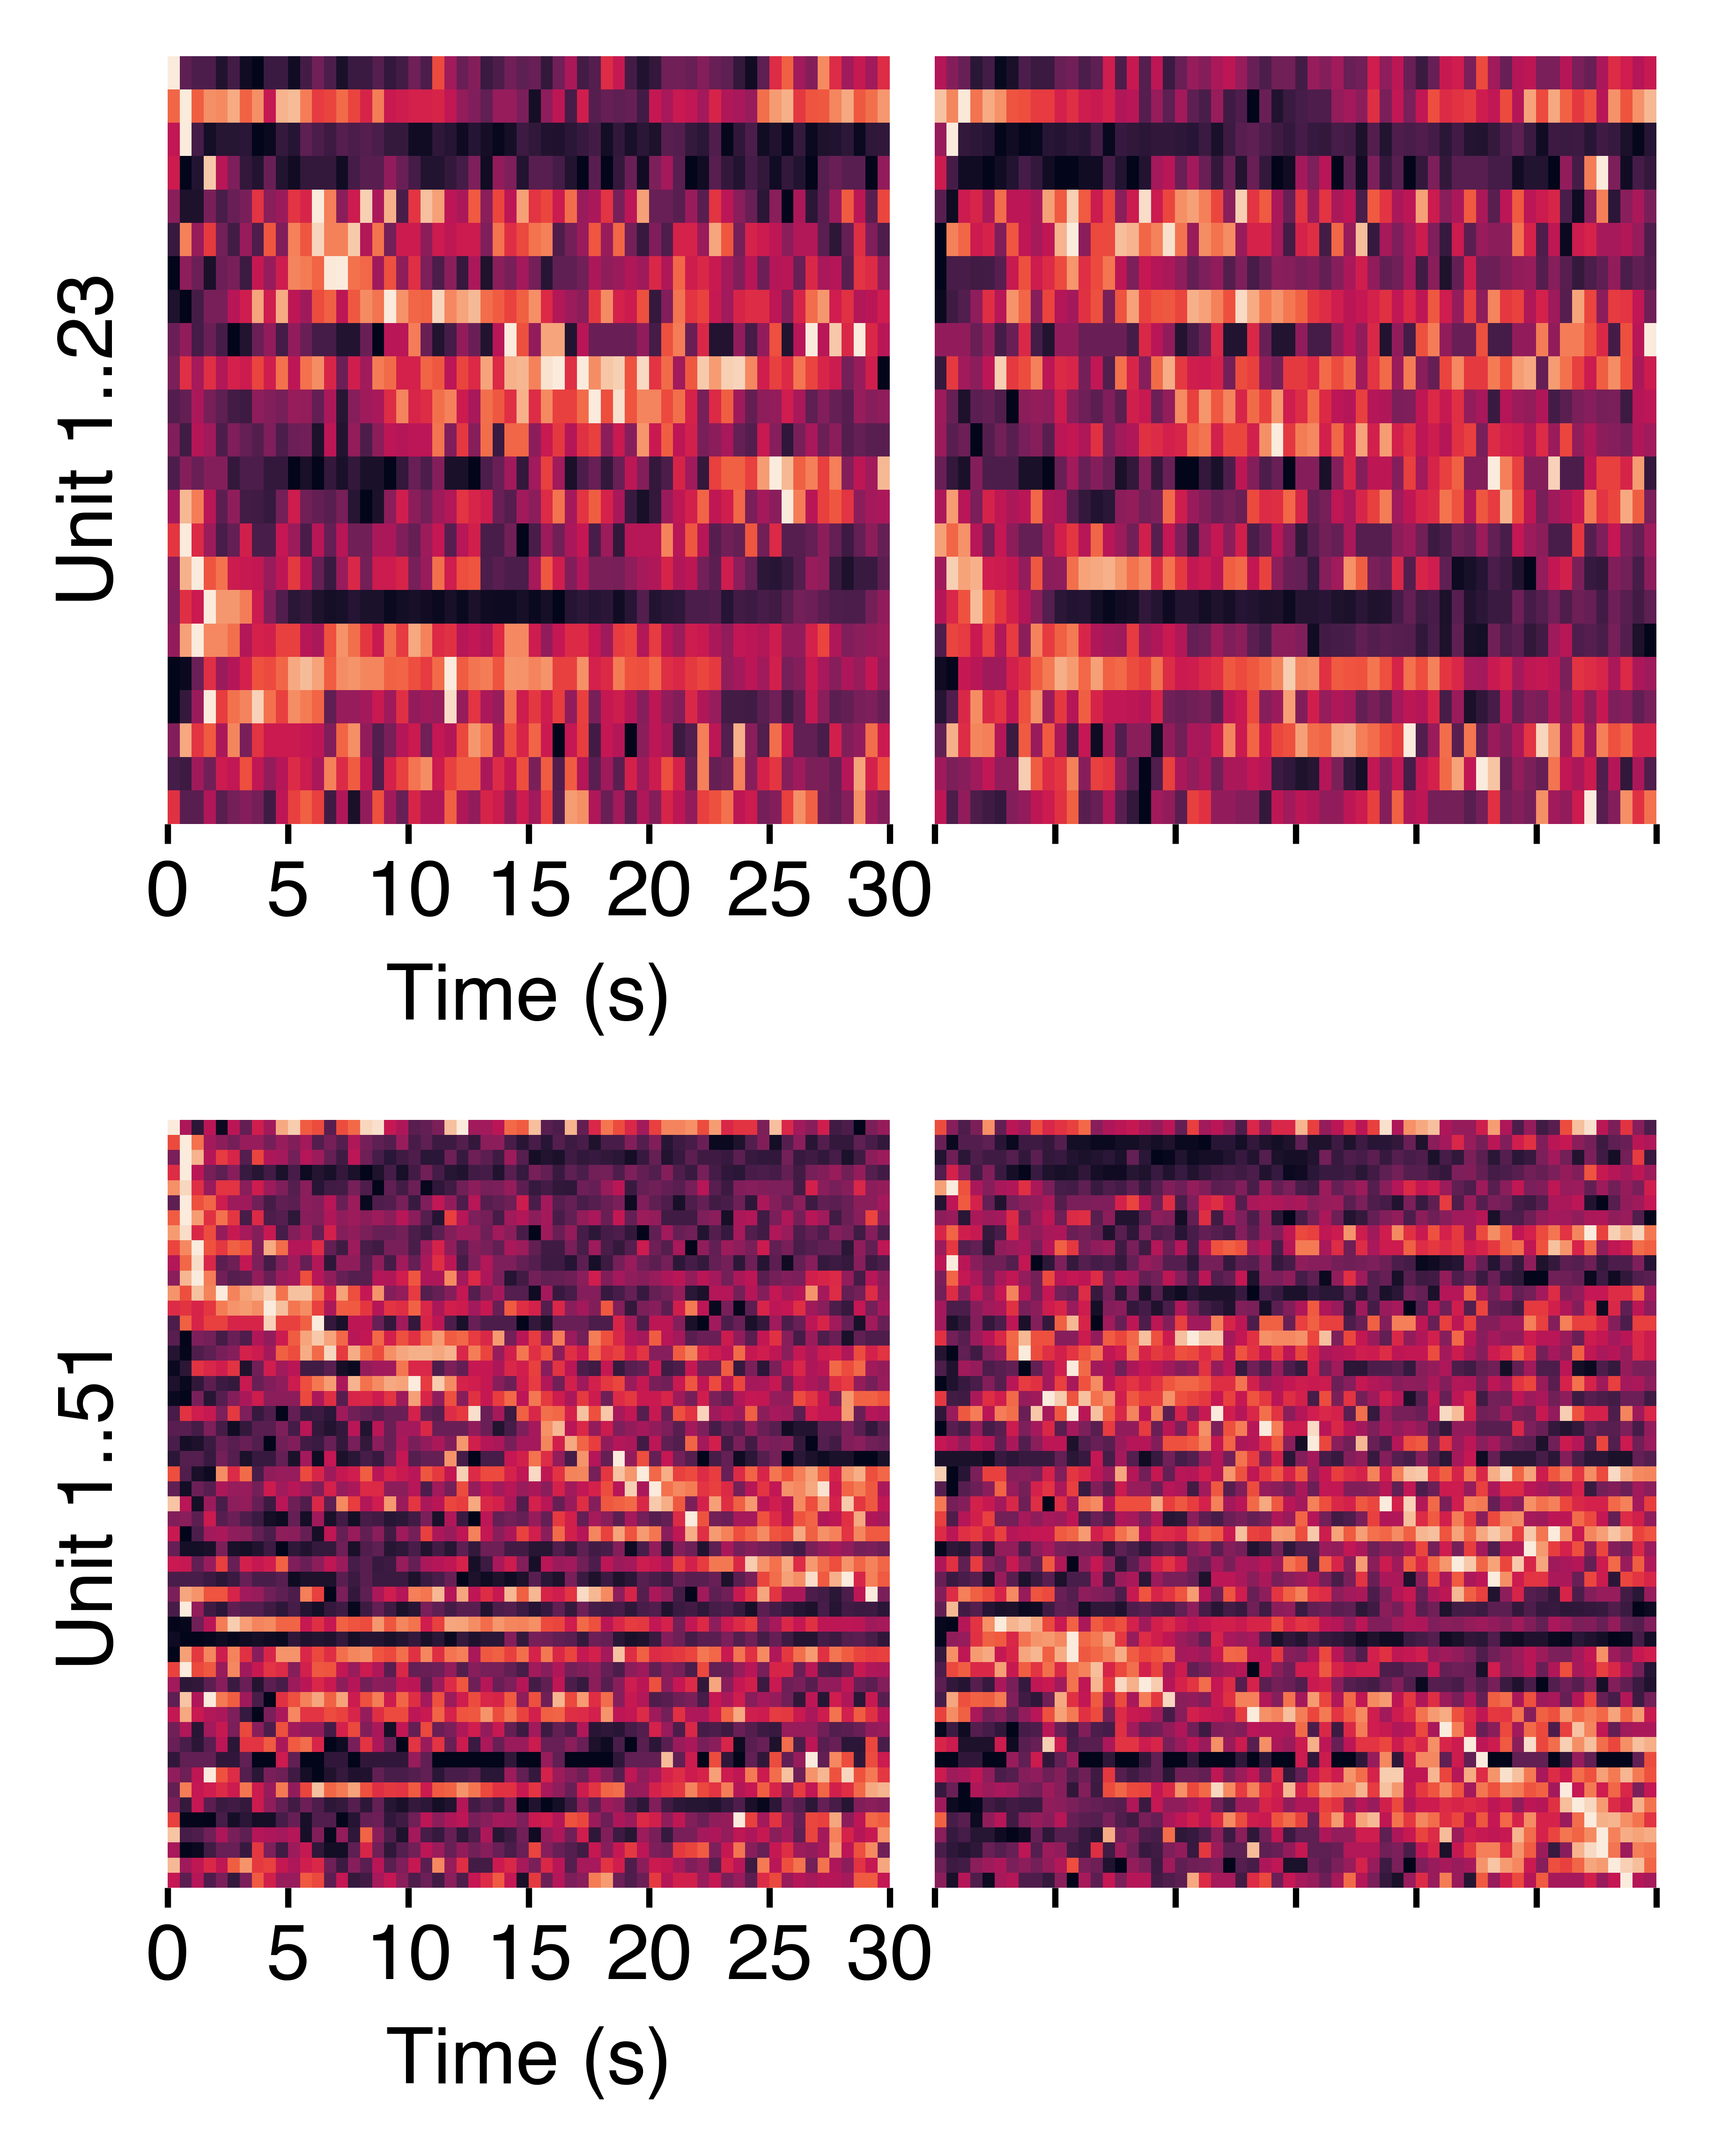

In [14]:
# Plot the mean timecourse for all Encoding and Retrieval neurons.
savefig = 1
overwrite = 1
remapped = True
figsize = (colws['2-1/2'], colws['2-1/2'] * 1.25)
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
xticks = np.arange(0, 61, step=10)
xticklabels = np.arange(0, 31, step=5, dtype=int)
plot_title = False
ax_labels = {0: 'Encoding', 1: 'Retrieval'}
add_cbar = False
vmin = 0
vmax = 1

plt.close()
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

n_neurons = time_remapping['neuron'].unique().size
for ii, remapped in enumerate([False, True]):
    iax = ii * 2
    
    # Sort neurons that we'll plot firing rates over time for.
    _neurons = time_remapping.query("(sig=={})".format(remapped)).groupby('gameState')['neuron'].apply(list)
    sbt_neurons = []
    for game_state in ['Encoding', 'Retrieval']:
        qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=={})".format(game_state, _neurons[game_state])
        sbt_neurons.extend(ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist())
    # _neurons = time_remapping.query("(sig=={})".format(remapped))['neuron'].tolist()
    # qry = "(gameState=='Encoding') & (testvar=='time') & (subj_sess_unit=={})".format(_neurons)
    # sbt_neurons = ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist()
    spikes_by_time = od([('Encoding', []), ('Retrieval', [])])
    for neuron in sbt_neurons:
        for game_state in ['Encoding', 'Retrieval']:
            qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=='{}')".format(game_state, neuron)
            _df = ols_pairs.query(qry)#
            assert len(_df) == 1
            spikes_by_time[game_state].append(_df.iloc[0]['mean_frs'])

    fr_mat = np.concatenate((np.array(spikes_by_time['Encoding']), np.array(spikes_by_time['Retrieval'])), axis=1)
    time_bins = int(fr_mat.shape[1] / 2)
    fr_mat = minmax_scale(fr_mat, axis=1)
    fr_mat = [fr_mat[:, :time_bins], fr_mat[:, time_bins:]]

    # Plot the firing rate heatmaps.
    for imat in range(2):
        ax[iax] = sns.heatmap(fr_mat[imat], vmin=vmin, vmax=vmax, cmap='rocket',
                            square=False, cbar=add_cbar, ax=ax[iax])
        ax[iax].tick_params(axis='x', which='both', length=2.5, pad=2)
        ax[iax].tick_params(axis='y', which='both', length=0, pad=2)
        ax[iax].set_xticks(xticks)
        ax[iax].set_yticks([])
        if iax in [0, 2]:
            ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
            ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=4)
            ax[iax].set_ylabel('Unit 1..{}'.format(fr_mat[0].shape[0]), fontsize=font['label'], labelpad=5)
        else:
            ax[iax].set_xticklabels([], fontsize=font['tick'], rotation=0)
        if plot_title:
            ax[iax].set_title(ax_labels[i], pad=6, fontsize=font['fig'])

        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'])
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
        iax += 1

fig.tight_layout(w_pad=0)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_remapping',
                       'nav_time_cell_remapping-{}units-mean_fr_over_time.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

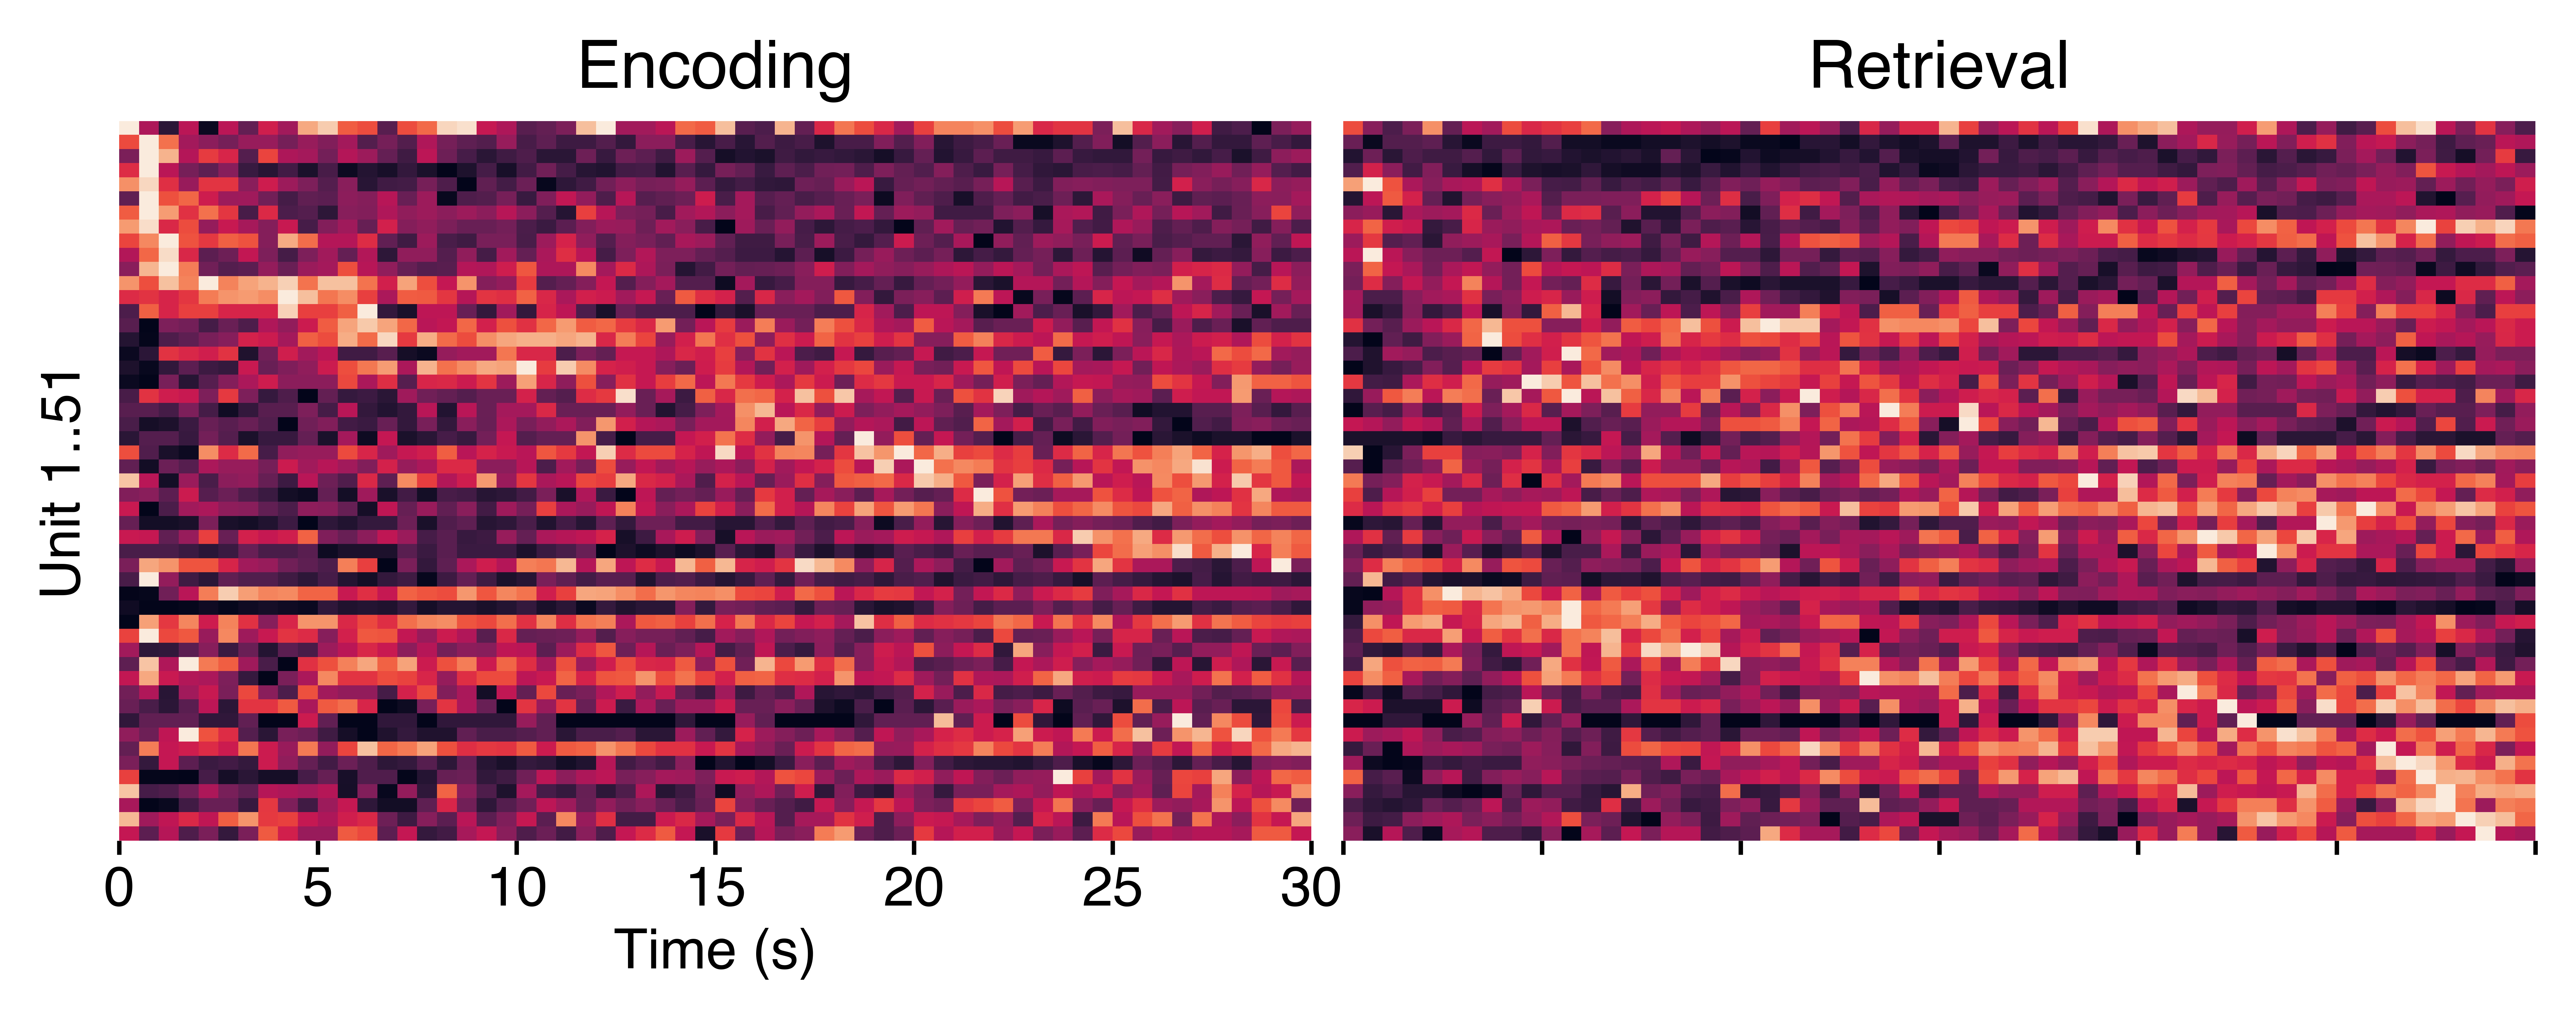

In [154]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 0
overwrite = 0
remapped = True
grid_shp = (15, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
ax_labels = {0: 'Encoding', 1: 'Retrieval'}
add_cbar = False
vmin = 0
vmax = 1

# Sort neurons that we'll plot firing rates over time for.
_neurons = time_remapping.query("(sig=={})".format(remapped)).groupby('gameState')['neuron'].apply(list)
sbt_neurons = []
for game_state in ['Encoding', 'Retrieval']:
    qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=={})".format(game_state, _neurons[game_state])
    sbt_neurons.extend(ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist())
# _neurons = time_remapping.query("(sig=={})".format(remapped))['neuron'].tolist()
# qry = "(gameState=='Encoding') & (testvar=='time') & (full=='full') & (subj_sess_unit=={})".format(_neurons)
# sbt_neurons = ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist()
spikes_by_time = od([('Encoding', []), ('Retrieval', [])])
for neuron in sbt_neurons:
    for game_state in ['Encoding', 'Retrieval']:
        qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=='{}')".format(game_state, neuron)
        _df = ols_pairs.query(qry)#
        assert len(_df) == 1
        spikes_by_time[game_state].append(_df.iloc[0]['mean_frs'])

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

fr_mat = np.concatenate((np.array(spikes_by_time['Encoding']), np.array(spikes_by_time['Retrieval'])), axis=1)
n_neurons = fr_mat.shape[0]
time_bins = int(fr_mat.shape[1] / 2)
fr_mat = minmax_scale(fr_mat, axis=1)
fr_mat = [fr_mat[:, :time_bins], fr_mat[:, time_bins:]]

# Plot the firing rate heatmaps.
for i in range(2):
    ax[i] = sns.heatmap(fr_mat[i], vmin=vmin, vmax=vmax, cmap='rocket',
                        square=False, cbar=add_cbar, ax=ax[i])
    ax[i].tick_params(axis='x', which='both', length=2.5, pad=2)
    ax[i].tick_params(axis='y', which='both', length=0, pad=2)
    ax[i].set_xticks(np.arange(0, fr_mat[i].shape[1]+1, 10))
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_xticklabels(np.arange(0, (fr_mat[i].shape[1]+1)/2, 5, dtype=np.int), 
                              fontsize=font['tick'], rotation=0)
        ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=2)
        ax[i].set_ylabel('Unit 1..{}'.format(fr_mat[0].shape[0]), fontsize=font['label'], labelpad=5)
    else:
        ax[i].set_xticklabels([], fontsize=font['tick'], rotation=0)
    ax[i].set_title(ax_labels[i], pad=6, fontsize=font['fig'])

    if add_cbar:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
fig.tight_layout(w_pad=0)
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_nav',
                       'nav_time_cells-{}units-Encoding_Retrieval_firing.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

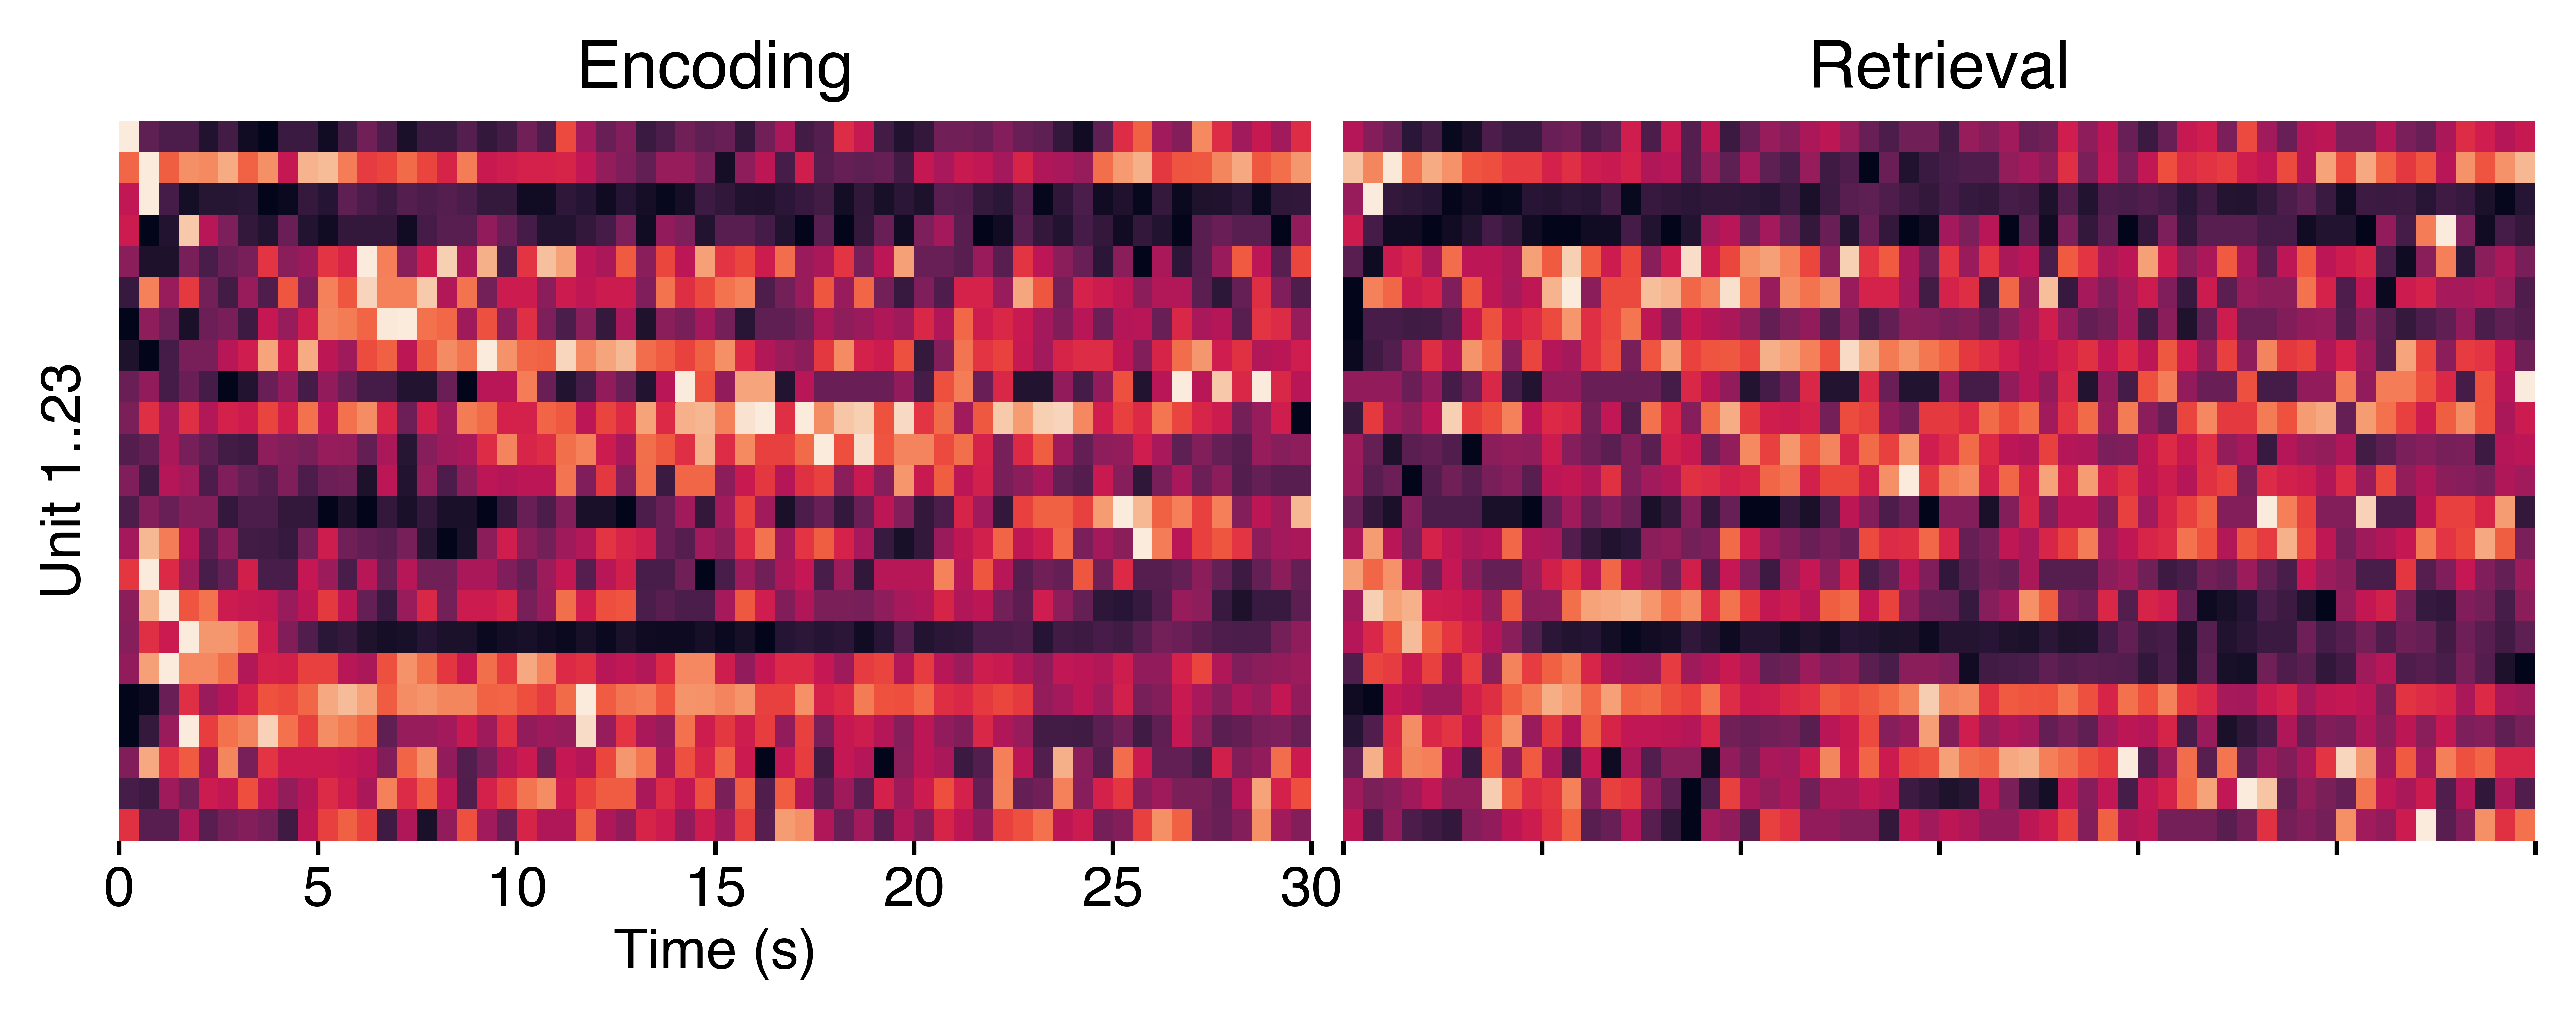

In [153]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 0
overwrite = 0
remapped = False
grid_shp = (15, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
ax_labels = {0: 'Encoding', 1: 'Retrieval'}
add_cbar = False
vmin = 0
vmax = 1

# Sort neurons that we'll plot firing rates over time for.
_neurons = time_remapping.query("(sig=={})".format(remapped)).groupby('gameState')['neuron'].apply(list)
sbt_neurons = []
for game_state in ['Encoding', 'Retrieval']:
    qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=={})".format(game_state, _neurons[game_state])
    sbt_neurons.extend(ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist())
# _neurons = time_remapping.query("(sig=={})".format(remapped))['neuron'].tolist()
# qry = "(gameState=='Encoding') & (testvar=='time') & (full=='full') & (subj_sess_unit=={})".format(_neurons)
# sbt_neurons = ols_pairs.query(qry).sort_values(['fr_max_ind', 'sparsity'])['subj_sess_unit'].tolist()
spikes_by_time = od([('Encoding', []), ('Retrieval', [])])
for neuron in sbt_neurons:
    for game_state in ['Encoding', 'Retrieval']:
        qry = "(gameState=='{}') & (testvar=='time') & (full=='full') & (subj_sess_unit=='{}')".format(game_state, neuron)
        _df = ols_pairs.query(qry)#
        assert len(_df) == 1
        spikes_by_time[game_state].append(_df.iloc[0]['mean_frs'])

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

fr_mat = np.concatenate((np.array(spikes_by_time['Encoding']), np.array(spikes_by_time['Retrieval'])), axis=1)
n_neurons = fr_mat.shape[0]
time_bins = int(fr_mat.shape[1] / 2)
fr_mat = minmax_scale(fr_mat, axis=1)
fr_mat = [fr_mat[:, :time_bins], fr_mat[:, time_bins:]]

# Plot the firing rate heatmaps.
for i in range(2):
    ax[i] = sns.heatmap(fr_mat[i], vmin=vmin, vmax=vmax, cmap='rocket',
                        square=False, cbar=add_cbar, ax=ax[i])
    ax[i].tick_params(axis='x', which='both', length=2.5, pad=2)
    ax[i].tick_params(axis='y', which='both', length=0, pad=2)
    ax[i].set_xticks(np.arange(0, fr_mat[i].shape[1]+1, 10))
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_xticklabels(np.arange(0, (fr_mat[i].shape[1]+1)/2, 5, dtype=np.int), 
                              fontsize=font['tick'], rotation=0)
        ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=2)
        ax[i].set_ylabel('Unit 1..{}'.format(fr_mat[0].shape[0]), fontsize=font['label'], labelpad=5)
    else:
        ax[i].set_xticklabels([], fontsize=font['tick'], rotation=0)
    ax[i].set_title(ax_labels[i], pad=6, fontsize=font['fig'])

    if add_cbar:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
fig.tight_layout(w_pad=0)
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_nav',
                       'nav_time_cells-{}units-Encoding_Retrieval_firing.pdf'
                       .format(n_neurons))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

# Place cell remapping

In [217]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [240]:
#event_spikes.get_spike_mat(neuron='time_bin', game_state='Encoding', column='maze_region', apply_f=len)[places].fillna(0)

In [242]:
is_odd = np.unique(event_spikes.event_spikes['trial']) % 2

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [237]:
event_spikes.event_spikes['is_odd'] = event_spikes.event_spikes['trial'].apply(lambda x: x % 2)

In [254]:
occupancy['Encoding'].index.values % 2 == 1

array([ True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False])

In [269]:
# Sum time bins in each maze region, separately for even and odd trials.
occupancy = od([('Encoding', event_spikes.get_spike_mat(neuron='time_bin', game_state='Encoding', column='maze_region', apply_f=len)[places].fillna(0)),
                ('Retrieval', event_spikes.get_spike_mat(neuron='time_bin', game_state='Retrieval', column='maze_region', apply_f=len)[places].fillna(0))])
for _k in occupancy:
    occupancy[_k] = (pd.concat((occupancy[_k].loc[occupancy[_k].index.values % 2 == 1, :].sum(),
                                occupancy[_k].loc[occupancy[_k].index.values % 2 == 0, :].sum()), axis=1)
                     .rename(columns={0: 'even', 1: 'odd'}).T)
    
place_remapping = []
for neuron, _df in grp:
    assert len(_df) == 2
    assert _df.iloc[0]['gameState'] == 'Encoding'
    assert _df.iloc[1]['gameState'] == 'Retrieval'
    
    subj_sess = _df.iloc[0]['subj_sess']
    nsig = _df['sig'].sum()
    assert nsig in [0, 1, 2]
    
    if 'event_spikes' not in dir():
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    elif event_spikes.subj_sess != subj_sess:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    
    # Sum spikes in each maze region, separately for even and odd trials.
    spike_mats = od([])
    for _, row in _df.iterrows():
        spike_mats[row['gameState']] = event_spikes.get_spike_mat(row['neuron'], row['gameState'], column='maze_region')[places].fillna(0)
        spike_mats[row['gameState']] = (pd.concat((spike_mats[row['gameState']].loc[spike_mats[row['gameState']].index.values % 2 == 1, :].sum(),
                                                   spike_mats[row['gameState']].loc[spike_mats[row['gameState']].index.values % 2 == 0, :].sum()), axis=1)
                                        .rename(columns={0: 'even', 1: 'odd'}).T)
        spike_mats[row['gameState']] = (spike_mats[row['gameState']] / occupancy[row['gameState']]).fillna(0)

In [273]:
spike_mats['Encoding']

maze_region,SW_Hall,SW_Room,NW_Room,NW_Hall,Base,S_Passage,C_Hall,N_Passage,SE_Hall,SE_Room,NE_Room,NE_Hall
even,2.111111,1.602941,2.516129,2.082192,1.942953,1.864865,2.917874,1.920635,1.893617,2.930233,1.600000,1.857143
odd,1.955224,1.691176,1.627451,2.196429,2.467742,2.680851,2.161290,2.266667,2.867647,2.755102,2.285714,1.200000


In [274]:
spike_mats['Retrieval']

maze_region,SW_Hall,SW_Room,NW_Room,NW_Hall,Base,S_Passage,C_Hall,N_Passage,SE_Hall,SE_Room,NE_Room,NE_Hall
even,2.746032,2.649123,2.16,1.692308,1.909091,1.673469,2.689286,1.914286,2.033333,2.758621,1.945946,1.814815
odd,2.297297,3.000000,2.70,2.426230,1.984211,1.641509,3.177143,2.102564,2.593750,3.303922,2.384615,1.607143


In [268]:
display(occupancy['Encoding'], occupancy['Retrieval'])

maze_region,SW_Hall,SW_Room,NW_Room,NW_Hall,Base,S_Passage,C_Hall,N_Passage,SE_Hall,SE_Room,NE_Room,NE_Hall
even,72.0,68.0,31.0,73.0,298.0,37.0,207.0,63.0,47.0,43.0,50.0,91.0
odd,67.0,68.0,51.0,56.0,310.0,47.0,248.0,60.0,68.0,49.0,21.0,35.0


maze_region,SW_Hall,SW_Room,NW_Room,NW_Hall,Base,S_Passage,C_Hall,N_Passage,SE_Hall,SE_Room,NE_Room,NE_Hall
even,63.0,57.0,50.0,39.0,242.0,49.0,280.0,35.0,60.0,87.0,37.0,81.0
odd,37.0,40.0,60.0,61.0,380.0,53.0,175.0,39.0,64.0,102.0,13.0,56.0


In [285]:
occupancy['Encoding']

maze_region,SW_Hall,SW_Room,NW_Room,NW_Hall,Base,S_Passage,C_Hall,N_Passage,SE_Hall,SE_Room,NE_Room,NE_Hall
trial,,,,,,,,,,,,
1,9.0,8.0,0.0,0.0,7.0,0.0,22.0,5.0,0.0,0.0,0.0,9.0
2,20.0,10.0,0.0,0.0,24.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
3,19.0,6.0,4.0,7.0,20.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,23.0,0.0,8.0,0.0,13.0,16.0,0.0,0.0
6,6.0,6.0,0.0,0.0,6.0,0.0,19.0,0.0,10.0,7.0,6.0,0.0
7,7.0,6.0,4.0,9.0,6.0,0.0,7.0,6.0,0.0,0.0,7.0,8.0
8,0.0,0.0,6.0,11.0,7.0,3.0,17.0,7.0,0.0,0.0,0.0,9.0
9,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,13.0,13.0,0.0,0.0


In [280]:
def get_occupancy(event_spikes):
    # Sum time bins in each maze region, separately for even and odd trials.
    occupancy = od([('Encoding', event_spikes.get_spike_mat(neuron='time_bin', game_state='Encoding', column='maze_region', apply_f=len)[places].fillna(0)),
                    ('Retrieval', event_spikes.get_spike_mat(neuron='time_bin', game_state='Retrieval', column='maze_region', apply_f=len)[places].fillna(0))])
    return occupancy

for _k in occupancy:
    if do_shuffle:
        
    occupancy[_k] = (pd.concat((occupancy[_k].loc[occupancy[_k].index.values % 2 == 1, :].sum(),
                                occupancy[_k].loc[occupancy[_k].index.values % 2 == 0, :].sum()), axis=1)
                     .rename(columns={0: 'even', 1: 'odd'}).T)

In [286]:
pairwise_sims_vec

array([0.98307547, 0.99026698, 0.96289399])

In [275]:
# Determine which place cells significantly remapped between Encoding and Retrieval
# by comparing the mean difference in firing rate cosine similarity between
# within-nav vs. between-nav trial pairs.
n_perm = 1000
alpha = 0.05

start_time = time()

places = ['SW_Hall', 'SW_Room', 'NW_Room', 'NW_Hall',
          'Base', 'S_Passage', 'C_Hall', 'N_Passage',
          'SE_Hall', 'SE_Room', 'NE_Room', 'NE_Hall']
all_cells = ols_pairs['subj_sess_unit'].unique()
qry = "(gameState==['Encoding', 'Retrieval']) & (testvar=='place') & (full=='full') & (sig==True)"
nav_place_cells = ols_pairs.query(qry)['subj_sess_unit'].unique()
qry = "(gameState==['Encoding', 'Retrieval']) & (testvar=='place') & (full=='full') & (subj_sess_unit=={})".format(list(nav_place_cells))
grp = (ols_pairs.sort_values(['subj_sess', 'neuron', 'gameState'])
       .query(qry)
       .groupby(['subj_sess_unit'], observed=True))

# Sum time bins in each maze region, separately for even and odd trials.
occupancy = od([('Encoding', event_spikes.get_spike_mat(neuron='time_bin', game_state='Encoding', column='maze_region', apply_f=len)[places].fillna(0)),
                ('Retrieval', event_spikes.get_spike_mat(neuron='time_bin', game_state='Retrieval', column='maze_region', apply_f=len)[places].fillna(0))])
for _k in occupancy:
    occupancy[_k] = (pd.concat((occupancy[_k].loc[occupancy[_k].index.values % 2 == 1, :].sum(),
                                occupancy[_k].loc[occupancy[_k].index.values % 2 == 0, :].sum()), axis=1)
                     .rename(columns={0: 'even', 1: 'odd'}).T)
    
place_remapping = []
for neuron, _df in grp:
    assert len(_df) == 2
    assert _df.iloc[0]['gameState'] == 'Encoding'
    assert _df.iloc[1]['gameState'] == 'Retrieval'
    
    subj_sess = _df.iloc[0]['subj_sess']
    nsig = _df['sig'].sum()
    assert nsig in [0, 1, 2]
    
    if 'event_spikes' not in dir():
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    elif event_spikes.subj_sess != subj_sess:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    
    # Sum spikes in each maze region, separately for even and odd trials.
    spike_mats = od([])
    for _, row in _df.iterrows():
        spike_mats[row['gameState']] = event_spikes.get_spike_mat(row['neuron'], row['gameState'], column='maze_region')[places].fillna(0)
        spike_mats[row['gameState']] = (pd.concat((spike_mats[row['gameState']].loc[spike_mats[row['gameState']].index.values % 2 == 1, :].sum(),
                                                   spike_mats[row['gameState']].loc[spike_mats[row['gameState']].index.values % 2 == 0, :].sum()), axis=1)
                                        .rename(columns={0: 'even', 1: 'odd'}).T)
        spike_mats[row['gameState']] = (spike_mats[row['gameState']] / occupancy[row['gameState']]).fillna(0)
    
    # Get Encoding to Retrieval firing vector sims.
    pairwise_sims = remapping.trial_pair_remapping(spike_mats)
    mean_sims = {k : np.mean(v) for k, v in pairwise_sims.items()}
    mean_sims['within'] = np.max((mean_sims['Encoding'], mean_sims['Retrieval']))
    asym = mean_sims['within'] - mean_sims['between']
    
    # Compute the null distribution.
    pairwise_sims_vec = np.concatenate([pairwise_sims['Encoding'],
                                        pairwise_sims['Retrieval'],
                                        pairwise_sims['between']]) # cond x trial_pair
    divs = np.cumsum((len(pairwise_sims['Encoding']), len(pairwise_sims['Retrieval']), len(pairwise_sims['between'])))[:2]
    asyms_null = []
    for iPerm in range(n_perm):
        np.random.shuffle(pairwise_sims_vec)
        mean_sims_null = dict(zip(['Encoding', 'Retrieval', 'between'], 
                                  [np.mean(x) for x in np.split(pairwise_sims_vec, divs)]))
        mean_sims_null['within'] = np.max((mean_sims_null['Encoding'], mean_sims_null['Retrieval']))
        asyms_null.append(mean_sims_null['within'] - mean_sims_null['between'])
    asyms_null = np.array(asyms_null)
    
    asym_z = (asym - np.mean(asyms_null)) / np.std(asyms_null)
    if asym_z > 0:
        asym_z_sign = 1
    elif asym_z == 0:
        asym_z_sign = 0
    else:
        asym_z_sign = -1
    pval_ind = np.sum(np.abs(asyms_null) >= np.abs(asym))
    pval = (1 + pval_ind) / (1 + n_perm)
    
    # Figure out which trial phase (Encoding or Retrieval) has stronger place coding.
    # (If only one trial phase is significant, take that one. Otherwise, take whichever
    # has the highest info score). Then add place coding info for the stronger trial phase.
    z_lr_diff = np.abs(np.diff(_df['z_lr']))[0]
    if nsig == 1:
        row = _df.query("(sig==True)").iloc[0]
    else:
        row = _df.sort_values('z_lr', ascending=False).iloc[0]
    game_state = row['gameState']
    z_lr = row['z_lr']
    fr_max_ind = row['fr_max_ind']
    place_remapping.append([neuron, subj_sess, nsig, z_lr_diff, game_state, z_lr,
                           fr_max_ind, asym, asym_z, asym_z_sign, pval_ind, pval])
        
place_remapping = pd.DataFrame(place_remapping, columns=['neuron', 'subj_sess', 'nsig', 'z_lr_diff', 'gameState', 'z_lr', 
                                                         'fr_max_ind', 'asym', 'asym_z', 'asym_z_sign', 'pval_ind', 'pval'])
place_remapping['sig'] = place_remapping['pval'] < alpha
place_remapping['asym_z_cat'] = 0
place_remapping.loc[(place_remapping['sig']==True) & (place_remapping['asym_z_sign']==-1), 'asym_z_cat'] = 1
place_remapping.loc[(place_remapping['sig']==True) & (place_remapping['asym_z_sign']==1), 'asym_z_cat'] = 2
place_remapping['dummy'] = 0
unit_to_roi_map = ols_pairs[['subj_sess_unit', 'roi_gen']].drop_duplicates().set_index('subj_sess_unit')['roi_gen'].to_dict()
place_remapping.insert(2, 'roi_gen', place_remapping['neuron'].apply(lambda x: unit_to_roi_map[x]))

print('place_remapping: {}'.format(place_remapping.shape))
print('Done in {:.1f}s'.format(time() - start_time))

place_remapping: (59, 16)
Done in 8.9s


In [228]:
# # Determine which place cells significantly remapped between Encoding and Retrieval
# # by comparing the mean difference in firing rate cosine similarity between
# # within-nav vs. between-nav trial pairs.
# n_perm = 1000
# alpha = 0.05

# start_time = time()

# places = ['SW_Hall', 'SW_Room', 'NW_Room', 'NW_Hall',
#           'Base', 'S_Passage', 'C_Hall', 'N_Passage',
#           'SE_Hall', 'SE_Room', 'NE_Room', 'NE_Hall']
# all_cells = ols_pairs['subj_sess_unit'].unique()
# qry = "(gameState==['Encoding', 'Retrieval']) & (testvar=='place') & (full=='full') & (sig==True)"
# nav_place_cells = ols_pairs.query(qry)['subj_sess_unit'].unique()
# qry = "(gameState==['Encoding', 'Retrieval']) & (testvar=='place') & (full=='full') & (subj_sess_unit=={})".format(list(nav_place_cells))
# grp = (ols_pairs.sort_values(['subj_sess', 'neuron', 'gameState'])
#        .query(qry)
#        .groupby(['subj_sess_unit'], observed=True))

# occupancy = od([('Encoding', event_spikes.get_spike_mat(neuron='time_bin', game_state='Encoding', column='maze_region', apply_f=len)[places].fillna(0)),
#                 ('Retrieval', event_spikes.get_spike_mat(neuron='time_bin', game_state='Retrieval', column='maze_region', apply_f=len)[places].fillna(0))])
# place_remapping = []
# for neuron, _df in grp:
#     assert len(_df) == 2
#     assert _df.iloc[0]['gameState'] == 'Encoding'
#     assert _df.iloc[1]['gameState'] == 'Retrieval'
    
#     subj_sess = _df.iloc[0]['subj_sess']
#     nsig = _df['sig'].sum()
#     assert nsig in [0, 1, 2]
    
#     if 'event_spikes' not in dir():
#         event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
#         event_spikes.event_spikes['is_odd'] = event_spikes.event_spikes['trial'].apply(lambda x: x % 2)
#     elif event_spikes.subj_sess != subj_sess:
#         event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
#         event_spikes.event_spikes['is_odd'] = event_spikes.event_spikes['trial'].apply(lambda x: x % 2)
    
#     spike_mats = od([])
#     for _, row in _df.iterrows():
#         spike_mats[row['gameState']] = (event_spikes.get_spike_mat(row['neuron'], row['gameState'], column='maze_region')[places].fillna(0) / occupancy[row['gameState']]).fillna(0)
    
#     # Get Encoding to Retrieval firing vector sims.
#     pairwise_sims = remapping.trial_pair_remapping(spike_mats)
#     mean_sims = {k : np.mean(v) for k, v in pairwise_sims.items()}
#     mean_sims['within'] = np.max((mean_sims['Encoding'], mean_sims['Retrieval']))
#     asym = mean_sims['within'] - mean_sims['between']
    
#     # Compute the null distribution.
#     pairwise_sims_vec = np.concatenate([pairwise_sims['Encoding'],
#                                         pairwise_sims['Retrieval'],
#                                         pairwise_sims['between']]) # cond x trial_pair
#     divs = np.cumsum((len(pairwise_sims['Encoding']), len(pairwise_sims['Retrieval']), len(pairwise_sims['between'])))[:2]
#     asyms_null = []
#     for iPerm in range(n_perm):
#         np.random.shuffle(pairwise_sims_vec)
#         mean_sims_null = dict(zip(['Encoding', 'Retrieval', 'between'], 
#                                   [np.mean(x) for x in np.split(pairwise_sims_vec, divs)]))
#         mean_sims_null['within'] = np.max((mean_sims_null['Encoding'], mean_sims_null['Retrieval']))
#         asyms_null.append(mean_sims_null['within'] - mean_sims_null['between'])
#     asyms_null = np.array(asyms_null)
    
#     asym_z = (asym - np.mean(asyms_null)) / np.std(asyms_null)
#     if asym_z > 0:
#         asym_z_sign = 1
#     elif asym_z == 0:
#         asym_z_sign = 0
#     else:
#         asym_z_sign = -1
#     pval_ind = np.sum(np.abs(asyms_null) >= np.abs(asym))
#     pval = (1 + pval_ind) / (1 + n_perm)
    
#     # Figure out which trial phase (Encoding or Retrieval) has stronger place coding.
#     # (If only one trial phase is significant, take that one. Otherwise, take whichever
#     # has the highest info score). Then add place coding info for the stronger trial phase.
#     z_lr_diff = np.abs(np.diff(_df['z_lr']))[0]
#     if nsig == 1:
#         row = _df.query("(sig==True)").iloc[0]
#     else:
#         row = _df.sort_values('z_lr', ascending=False).iloc[0]
#     game_state = row['gameState']
#     z_lr = row['z_lr']
#     fr_max_ind = row['fr_max_ind']
#     place_remapping.append([neuron, subj_sess, nsig, z_lr_diff, game_state, z_lr,
#                            fr_max_ind, asym, asym_z, asym_z_sign, pval_ind, pval])
        
# place_remapping = pd.DataFrame(place_remapping, columns=['neuron', 'subj_sess', 'nsig', 'z_lr_diff', 'gameState', 'z_lr', 
#                                                      'fr_max_ind', 'asym', 'asym_z', 'asym_z_sign', 'pval_ind', 'pval'])
# place_remapping['sig'] = place_remapping['pval'] < alpha
# place_remapping['asym_z_cat'] = 0
# place_remapping.loc[(place_remapping['sig']==True) & (place_remapping['asym_z_sign']==-1), 'asym_z_cat'] = 1
# place_remapping.loc[(place_remapping['sig']==True) & (place_remapping['asym_z_sign']==1), 'asym_z_cat'] = 2
# place_remapping['dummy'] = 0
# unit_to_roi_map = ols_pairs[['subj_sess_unit', 'roi_gen']].drop_duplicates().set_index('subj_sess_unit')['roi_gen'].to_dict()
# place_remapping.insert(2, 'roi_gen', place_remapping['neuron'].apply(lambda x: unit_to_roi_map[x]))

# print('place_remapping: {}'.format(place_remapping.shape))
# print('Done in {:.1f}s'.format(time() - start_time))

/home1/dscho/code/general/array_operations.py:25: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


place_remapping: (59, 16)
Dont in 11.2s


In [278]:
place_remapping.sort_values('asym', ascending=False)

,neuron,subj_sess,roi_gen,nsig,z_lr_diff,gameState,z_lr,fr_max_ind,asym,asym_z,asym_z_sign,pval_ind,pval,sig,asym_z_cat,dummy
29,U521_ses0-22-1,U521_ses0,MTL,2,2.164678,Encoding,6.567146,20,0.443886,1.245027,1,342,0.342657,False,0,0
24,U521_ses0-19-1,U521_ses0,MTL,1,3.397579,Retrieval,4.200311,19,0.421214,0.939573,1,323,0.323676,False,0,0
28,U521_ses0-21-2,U521_ses0,MTL,1,0.952937,Encoding,2.893284,32,0.395832,1.143850,1,339,0.339660,False,0,0
22,U521_ses0-17-1,U521_ses0,MTL,1,2.236751,Encoding,4.130366,18,0.391654,1.253961,1,331,0.331668,False,0,0
27,U521_ses0-21-1,U521_ses0,MTL,2,2.168615,Retrieval,7.368717,13,0.382833,1.148443,1,349,0.349650,False,0,0
30,U521_ses0-22-2,U521_ses0,MTL,1,3.995531,Encoding,6.019466,13,0.380598,1.234187,1,338,0.338661,False,0,0
23,U521_ses0-17-2,U521_ses0,MTL,1,0.087582,Retrieval,2.960685,13,0.361315,1.190128,1,354,0.354645,False,0,0
26,U521_ses0-19-4,U521_ses0,MTL,1,5.982148,Retrieval,5.761038,0,0.330625,1.354395,1,326,0.326673,False,0,0
25,U521_ses0-19-2,U521_ses0,MTL,1,3.316476,Retrieval,4.669747,8,0.294026,1.419685,1,323,0.323676,False,0,0
15,U518_ses1-43-2,U518_ses1,MTL,2,5.613727,Encoding,11.867134,2,0.271397,0.799380,1,342,0.342657,False,0,0


In [229]:
place_remapping

,neuron,subj_sess,roi_gen,nsig,z_lr_diff,gameState,z_lr,fr_max_ind,asym,asym_z,asym_z_sign,pval_ind,pval,sig,asym_z_cat,dummy
0,U518_ses0-11-1,U518_ses0,Cortex,1,2.008408,Retrieval,3.031976,26,0.070384,0.162016,1,531,0.531469,False,0,0
1,U518_ses0-35-1,U518_ses0,Hippocampus,1,3.186775,Encoding,2.985922,2,0.007408,-0.395001,-1,934,0.934066,False,0,0
2,U518_ses0-42-1,U518_ses0,MTL,1,4.412564,Retrieval,6.814738,31,0.097321,0.457407,1,367,0.367632,False,0,0
3,U518_ses0-44-1,U518_ses0,MTL,1,7.244449,Encoding,6.353163,0,0.111333,0.559248,1,360,0.360639,False,0,0
4,U518_ses0-65-1,U518_ses0,Cortex,2,6.172127,Retrieval,16.604603,29,0.166452,0.772588,1,236,0.236763,False,0,0
5,U518_ses0-67-1,U518_ses0,Cortex,2,4.379074,Encoding,16.983888,3,0.023468,-0.090617,-1,687,0.687313,False,0,0
6,U518_ses0-67-2,U518_ses0,Cortex,2,0.212106,Encoding,6.427400,3,-0.025431,-0.734249,-1,796,0.796204,False,0,0
7,U518_ses0-68-1,U518_ses0,Cortex,2,1.166663,Encoding,17.221596,3,0.062265,0.651295,1,284,0.284715,False,0,0
8,U518_ses0-9-1,U518_ses0,Cortex,2,0.266411,Retrieval,3.198980,46,0.113388,0.730046,1,269,0.269730,False,0,0
9,U518_ses1-12-1,U518_ses1,Cortex,1,4.049723,Encoding,3.330519,20,0.199099,0.795953,1,237,0.237762,False,0,0
